# PROJECT: Forecasting System Retail - Predictive Models

# 1. Initial Formatting of Jupyter Notebook

In [1]:
import pymysql
import pandas as pd
import datetime
import seaborn as sns
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
from sqlalchemy import create_engine

ohc = OneHotEncoder()
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set(rc={"figure.figsize":(16, 6)})

# 2. MYSQL Connection

In [2]:
#CORPORATE CONFIDENTIAL DATASET
#CONFIDENTIAL ACCESS DATA
# MySQL connection
db_connection = pymysql.connect(host = 'xxx.x.xxx.xxx',
                                user = 'xxxxxxx',
                                password = 'xxxxx',
                                database = 'xxxx')

# 3. Data cleaning & Transformation

In [3]:
calendar = pd.read_sql('SELECT * FROM calendar', con = db_connection)
calendar

,REL_DAY,DAY_DATE
0,1,2013-01-01
1,2,2013-01-02
2,3,2013-01-03
3,4,2013-01-04
4,5,2013-01-05
...,...,...
4011,4012,2023-12-26
4012,4013,2023-12-27
4013,4014,2023-12-28
4014,4015,2023-12-29


In [4]:
store = pd.read_sql('SELECT * FROM store', con = db_connection)
store

,STORE_KEY,CITY,STATE
0,-1,None,None
1,1,CRICIÚMA,SC
2,2,IMBITUBA,SC
3,3,CRICIÚMA,SC
4,4,URUSSANGA,SC
5,5,GAROPABA,SC
6,6,ORLEANS,SC
7,7,LAGUNA,SC
8,8,TUBARÃO,SC
9,9,CRICIÚMA,SC


In [5]:
price_zone = pd.read_sql('SELECT * FROM price_zone', con = db_connection)
price_zone

,PZ_KEY,PZ_DESC,PZ_GROUP_KEY,PZ_GROUP_DESC
0,2,F01 IMBITUBA,1,IMBITUBA
1,3,F05 CRICIUMA,2,CRICIUMA
2,4,F07 URUSSSANGA,3,URUSSSANGA
3,5,F10 GAROPABA,4,GAROPABA
4,6,F11 ORLEANS,5,ORLEANS
5,7,F12 LAGUNA,6,LAGUNA
6,8,F14 TUBARAO,7,TUBARAO
7,9,F15 PINHEIRINHO,8,PINHEIRINHO
8,10,F16 COCAL D SUL,9,COCAL DO SUL
9,11,F17 CARAVAGGIO,10,CARAVAGGIO


In [6]:
pz_store = pd.read_sql('SELECT * FROM pz_store', con = db_connection)
pz_store

,STORE_KEY,PZ_KEY,PZG_KEY
0,2,2,1
1,3,3,2
2,4,4,3
3,5,5,4
4,6,6,5
5,7,7,6
6,8,8,7
7,9,9,8
8,10,10,9
9,13,13,11


In [7]:
item = pd.read_sql('SELECT * FROM item', con = db_connection)
item

,SKU_KEY,SKU_DESC,MERCH_L2_KEY,MERCH_L2_DESC,MERCH_L3_KEY,MERCH_L3_DESC,MERCH_L4_KEY,MERCH_L4_DESC,MERCH_L5_KEY,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS
0,19516,LEITE STA CLARA INTEGRAL TP 1L C/12,2,PERECIVEIS,5,FLC,76,LEITE,1753,INTEGRAL,120000.0,UN,10.0
1,19517,LEITE STA CLARA DESNATADO TP 1L C/12,2,PERECIVEIS,5,FLC,76,LEITE,1755,DESNATADO,120000.0,UN,10.0
2,19518,LEITE STA CLARA SEMIDESNATADO TP 1L C/12,2,PERECIVEIS,5,FLC,76,LEITE,1754,SEMI DESNATADO,120000.0,UN,10.0
3,19519,CHOCOLATE PO NUTRIMAX TANGARA 50 1KG,3,NAO PERECIVEIS,16,MATERIA-PRIMA,54,TERCEIRIZADA,1678,SECA,10000.0,UN,10.0
4,19520,CERVEJA SAINT BIER AMERICA LAGER 600ML,3,NAO PERECIVEIS,13,BEBIDAS,143,CERVEJA ESPECIAL,416,GARRAFA,6000000.0,UN,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30824,30969,LIVRO ARTE&CRIATIVIDADE CELEIRO,3,NAO PERECIVEIS,8,BAZAR,253,LIVROS,1607,INFANTIL,10000.0,UN,10.0
30825,30968,LIVRO ARTE&CRIATIVIDADE CARROS RADICAIS,3,NAO PERECIVEIS,8,BAZAR,253,LIVROS,1607,INFANTIL,10000.0,UN,10.0
30826,30973,LIVRO ORACOES P/PEQ CORAC BOX C/6,3,NAO PERECIVEIS,8,BAZAR,253,LIVROS,1607,INFANTIL,10000.0,UN,10.0
30827,30961,ALCOOL ARARAS 46 INPM FR 1L,3,NAO PERECIVEIS,15,LIMPEZA,203,INFLAMAVEIS,796,QUEROSENE,10000.0,UN,10.0


In [8]:
sales_stock = pd.read_sql('SELECT * FROM sales_stock', con = db_connection)
sales_stock

,STORE_KEY,SKU_KEY,REL_DAY,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,SOH_QTY,SOH_VAL
0,6,1960,2505,10,1,6,P,114,713
1,5,24536,2505,2,1,2,R,42,71
2,5,24496,2505,10,2,6,R,156,453
3,5,25831,2505,7,1,4,R,24,91
4,5,26086,2505,7,3,4,P,189,282
...,...,...,...,...,...,...,...,...,...
17926508,10,3378,3222,4,1,2,R,5,11
17926509,10,8792,3222,2,1,1,R,8,7
17926510,10,6490,3222,7,2,3,R,46,79
17926511,10,8863,3222,13,1,6,R,3,18


# Join Tables

In [9]:
join_tables=pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(sales_stock,item,how='left',on='SKU_KEY'),calendar,how='left',on='REL_DAY'),store,how='left',on='STORE_KEY'),pz_store,how='left',on='STORE_KEY'),price_zone,how='left',left_on=['PZ_KEY','PZG_KEY'],right_on=['PZ_KEY','PZ_GROUP_KEY'])
join_tables

,STORE_KEY,SKU_KEY,REL_DAY,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,SOH_QTY,SOH_VAL,SKU_DESC,MERCH_L2_KEY,MERCH_L2_DESC,MERCH_L3_KEY,MERCH_L3_DESC,MERCH_L4_KEY,MERCH_L4_DESC,MERCH_L5_KEY,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,DAY_DATE,CITY,STATE,PZ_KEY,PZG_KEY,PZ_DESC,PZ_GROUP_KEY,PZ_GROUP_DESC
0,6,1960,2505,10,1,6,P,114,713,AGUARDENTE 51 GFA 965ML,3,NAO PERECIVEIS,13,BEBIDAS,144,DESTILADOS,421,CACHACA,9650000.0,UN,10.0,2019-11-10,ORLEANS,SC,6,5,F11 ORLEANS,5,ORLEANS
1,5,24536,2505,2,1,2,R,42,71,SAB OXYCLEAR FLOR CEREJEIRA BR 180G,3,NAO PERECIVEIS,14,HIGIENE,206,SABONETE,1388,BARRA,180000.0,UN,10.0,2019-11-10,GAROPABA,SC,5,4,F10 GAROPABA,4,GAROPABA
2,5,24496,2505,10,2,6,R,156,453,QUEIJO FAIXA AZUL PARMESAO RALADO PCT 50,2,PERECIVEIS,5,FLC,105,QUEIJOS,1238,QUEIJO RALADO,500000.0,UN,10.0,2019-11-10,GAROPABA,SC,5,4,F10 GAROPABA,4,GAROPABA
3,5,25831,2505,7,1,4,R,24,91,ACHOC NESTLE CLASSIC PT 200G,3,NAO PERECIVEIS,12,MERCEARIA,132,ACHOCOLATADO,329,TRADICIONAL,2000000.0,UN,10.0,2019-11-10,GAROPABA,SC,5,4,F10 GAROPABA,4,GAROPABA
4,5,26086,2505,7,3,4,P,189,282,TORRADA ISABELA TRADICIONAL PCT 142G,3,NAO PERECIVEIS,12,MERCEARIA,91,TORRADAS,702,NACIONAL,1420000.0,UN,10.0,2019-11-10,GAROPABA,SC,5,4,F10 GAROPABA,4,GAROPABA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17926508,10,3378,3222,4,1,2,R,5,11,LIMP CASA & PERFUME BELA FLORE FR 500ML,3,NAO PERECIVEIS,15,LIMPEZA,196,LIMPADOR,753,PERFUMADOS,5000000.0,UN,10.0,2021-10-27,COCAL DO SUL,SC,10,9,F16 COCAL D SUL,9,COCAL DO SUL
17926509,10,8792,3222,2,1,1,R,8,7,CALDO ARISCO CARNE CX 57G,3,NAO PERECIVEIS,12,MERCEARIA,87,TEMPEROS,653,CALDO,570000.0,UN,10.0,2021-10-27,COCAL DO SUL,SC,10,9,F16 COCAL D SUL,9,COCAL DO SUL
17926510,10,6490,3222,7,2,3,R,46,79,BATATA PALHA KI FRITAS EXTRAFINA PCT 80G,3,NAO PERECIVEIS,12,MERCEARIA,131,BATATA PALHA,327,TRADICIONAL,800000.0,UN,10.0,2021-10-27,COCAL DO SUL,SC,10,9,F16 COCAL D SUL,9,COCAL DO SUL
17926511,10,8863,3222,13,1,6,R,3,18,SAPON CIF CREMOSO LIMAO FR 450ML,3,NAO PERECIVEIS,15,LIMPEZA,193,SAPONACEO,744,LIQUIDO,4500000.0,UN,10.0,2021-10-27,COCAL DO SUL,SC,10,9,F16 COCAL D SUL,9,COCAL DO SUL


In [10]:
join_tables['SLS_VAL'].describe()

count    1.792651e+07
mean     3.194587e+01
std      9.708939e+01
min      0.000000e+00
25%      6.000000e+00
50%      1.200000e+01
75%      2.700000e+01
max      1.977000e+04
Name: SLS_VAL, dtype: float64

In [11]:
join_tables['SLS_VAL'].isna().sum()

0

In [12]:
join_tables.loc[join_tables['SLS_VAL'] == 0]

,STORE_KEY,SKU_KEY,REL_DAY,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,SOH_QTY,SOH_VAL,SKU_DESC,MERCH_L2_KEY,MERCH_L2_DESC,MERCH_L3_KEY,MERCH_L3_DESC,MERCH_L4_KEY,MERCH_L4_DESC,MERCH_L5_KEY,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,DAY_DATE,CITY,STATE,PZ_KEY,PZG_KEY,PZ_DESC,PZ_GROUP_KEY,PZ_GROUP_DESC
265,5,25136,2505,0,0,0,R,17,37,DESUMIDIFICADOR SECAR NATURAL PT 80G,3,NAO PERECIVEIS,15,LIMPEZA,20,DESODORIZADOR,771,AMBIENTE,800000.0,UN,10.0,2019-11-10,GAROPABA,SC,5,4,F10 GAROPABA,4,GAROPABA
1200,6,22894,2505,0,0,0,R,74,172,CERVEJA ITAIPAVA PREMIUM PILSEN LT 350ML,3,NAO PERECIVEIS,13,BEBIDAS,142,CERVEJA PREMIUM,411,PILSEN,3500000.0,UN,10.0,2019-11-10,ORLEANS,SC,6,5,F11 ORLEANS,5,ORLEANS
3272,8,6535,2505,0,1,0,P,89,41,REFRESCO MAGRO DIET LIMAO PCT 8G,3,NAO PERECIVEIS,13,BEBIDAS,139,REFRESCO PO,401,DIET/LIGHT,80000.0,UN,10.0,2019-11-10,TUBARÃO,SC,8,7,F14 TUBARAO,7,TUBARAO
4942,5,6533,2505,0,2,1,P,17,8,REFRESCO MAGRO DIET PESSEGO PCT 8G,3,NAO PERECIVEIS,13,BEBIDAS,139,REFRESCO PO,401,DIET/LIGHT,80000.0,UN,10.0,2019-11-10,GAROPABA,SC,5,4,F10 GAROPABA,4,GAROPABA
5914,2,1816,2505,0,0,0,R,4,80,ENTRECOTE BOV DISTRIBOI CRY KG,2,PERECIVEIS,4,CARNES,70,CARNE BOVINA ESPECIAL,978,ENTRECORTE,10000.0,KG,10.0,2019-11-10,IMBITUBA,SC,2,1,F01 IMBITUBA,1,IMBITUBA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17922917,2,20512,3222,0,0,0,R,1,7,CHOCOLATE PO DR OETKER 70 CACAU CX 200G,3,NAO PERECIVEIS,12,MERCEARIA,120,COBERTURA/RECHEIO,729,CHOCOLATE PO,2000000.0,UN,10.0,2021-10-27,IMBITUBA,SC,2,1,F01 IMBITUBA,1,IMBITUBA
17923737,4,43,3222,0,0,0,R,106,160,MELANCIA KG,2,PERECIVEIS,7,FLV,48,FRUTAS,841,MELANCIA,10000.0,KG,10.0,2021-10-27,URUSSANGA,SC,4,3,F07 URUSSSANGA,3,URUSSSANGA
17924890,2,9801,3222,0,0,0,R,3,21,CHUPETA KUKA ORTOD VENTILADA SILIC RS N2,3,NAO PERECIVEIS,14,HIGIENE,24,INFANTIL,1434,PUERICULTURA,10000.0,UN,10.0,2021-10-27,IMBITUBA,SC,2,1,F01 IMBITUBA,1,IMBITUBA
17924900,4,14,3222,0,0,0,P,8,43,GENGIBRE KG,2,PERECIVEIS,7,FLV,49,LEGUMES,865,GENGIBRE,10000.0,KG,10.0,2021-10-27,URUSSANGA,SC,4,3,F07 URUSSSANGA,3,URUSSSANGA


In [13]:
join_tables.loc[join_tables['SLS_VAL'] == 19770]

,STORE_KEY,SKU_KEY,REL_DAY,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,SOH_QTY,SOH_VAL,SKU_DESC,MERCH_L2_KEY,MERCH_L2_DESC,MERCH_L3_KEY,MERCH_L3_DESC,MERCH_L4_KEY,MERCH_L4_DESC,MERCH_L5_KEY,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,DAY_DATE,CITY,STATE,PZ_KEY,PZG_KEY,PZ_DESC,PZ_GROUP_KEY,PZ_GROUP_DESC
17138824,8,18260,3190,19770,551,19505,P,0,0,LEITE PARMALAT INTEGRAL TP 1L C/12,2,PERECIVEIS,5,FLC,76,LEITE,1753,INTEGRAL,120000.0,UN,10.0,2021-09-25,TUBARÃO,SC,8,7,F14 TUBARAO,7,TUBARAO


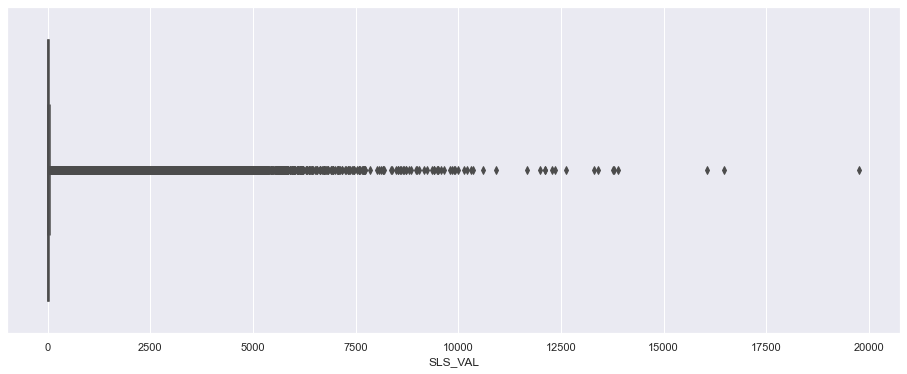

In [14]:
sns.boxplot(join_tables['SLS_VAL']);

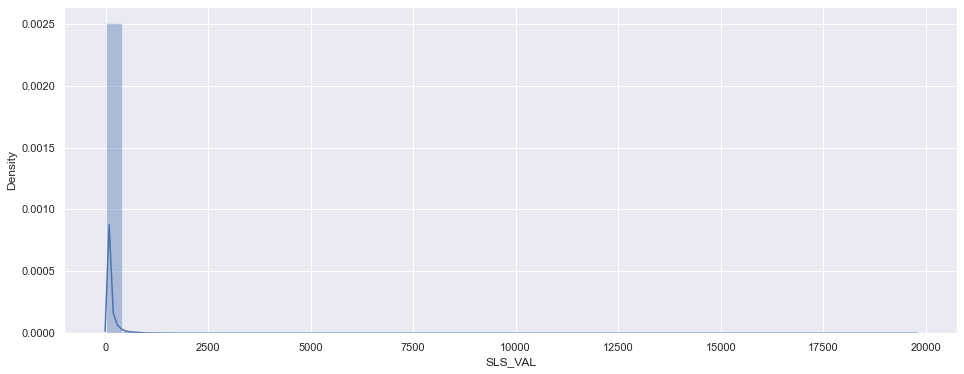

In [15]:
sns.distplot(join_tables['SLS_VAL']);

In [16]:
join_tables['YEAR'] = join_tables['DAY_DATE'].dt.year
join_tables['MONTH'] = join_tables['DAY_DATE'].dt.month
join_tables['DAY'] = join_tables['DAY_DATE'].dt.day
join_tables['WEEK_NUMBER'] = join_tables['DAY_DATE'].dt.week
join_tables['DAY_OF_WEEK'] = join_tables['DAY_DATE'].dt.dayofweek

In [17]:
df = join_tables.groupby(['DAY_DATE','YEAR','MONTH'])['SLS_VAL'].sum().reset_index()
df

,DAY_DATE,YEAR,MONTH,SLS_VAL
0,2019-11-10,2019,11,595240
1,2019-11-11,2019,11,583409
2,2019-11-12,2019,11,552906
3,2019-11-13,2019,11,606459
4,2019-11-14,2019,11,810178
...,...,...,...,...
705,2021-10-23,2021,10,1097389
706,2021-10-24,2021,10,648986
707,2021-10-25,2021,10,626921
708,2021-10-26,2021,10,640518


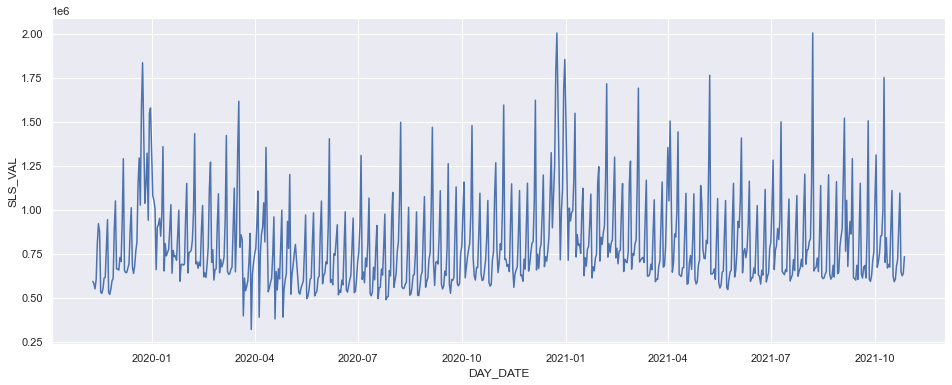

In [18]:
sns.lineplot(data=df,x='DAY_DATE',y='SLS_VAL');

In [19]:
df1 = join_tables.groupby(['YEAR','MONTH'])['SLS_VAL'].sum().reset_index()
df1

,YEAR,MONTH,SLS_VAL
0,2019,11,14282774
1,2019,12,28945832
2,2020,1,25223001
3,2020,2,23918611
4,2020,3,24062628
5,2020,4,21481022
6,2020,5,19832651
7,2020,6,20857443
8,2020,7,21778928
9,2020,8,22293168


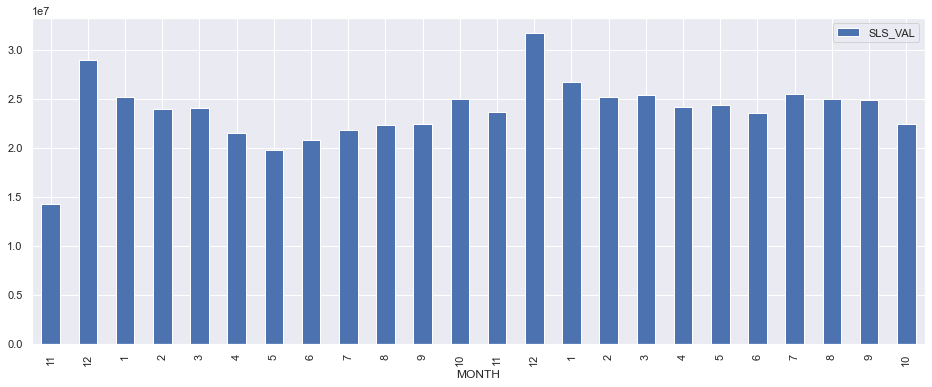

In [20]:
df1.plot.bar(x='MONTH',y='SLS_VAL');

## Sample Selection

In [21]:
df2 = join_tables.groupby(['STORE_KEY'])['SLS_VAL'].sum()
df2

STORE_KEY
2     130147059
3      29384143
4      50157457
5      84705280
6      60962276
7      90888989
8      36625533
9      31969679
10     24624664
11     13632910
13     19580070
Name: SLS_VAL, dtype: int64

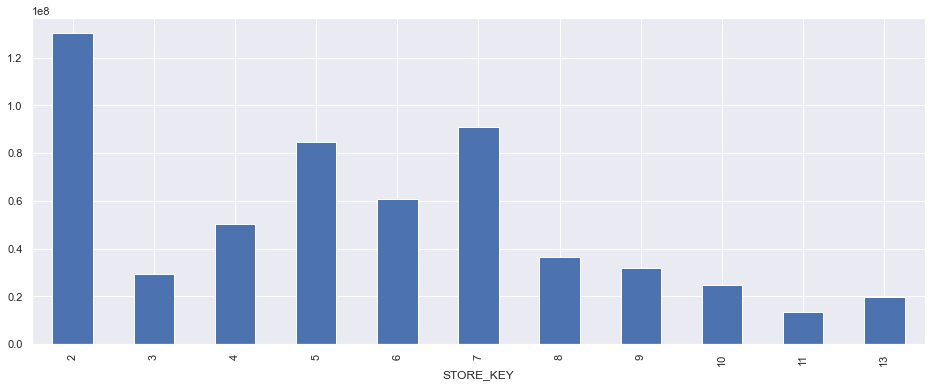

In [22]:
df2.plot.bar(x='STORE_KEY',y='SLS_VAL');

In [23]:
df2.mean()

52061641.81818182

In [24]:
df3 = join_tables[['STORE_KEY', 'CITY', 'STATE', 'DAY_DATE','YEAR', 'MONTH', 'DAY', 'WEEK_NUMBER', 'DAY_OF_WEEK', 'SKU_KEY', 'SKU_DESC', 'MERCH_L2_DESC', 'MERCH_L3_DESC', 'MERCH_L4_DESC', 'MERCH_L5_DESC', 'PACKAGE_SIZE', 'PACKAGE_UOM', 'PACKAGE_NO_UNITS', 'SLS_VAL', 'SLS_QTY', 'COST_SLS_VAL', 'TRAN_TYPE', 'PZ_DESC', 'PZ_GROUP_DESC', 'SOH_QTY', 'SOH_VAL']]

In [25]:
store_2 = df3.loc[df3['STORE_KEY'] == 2]
store_2

,STORE_KEY,CITY,STATE,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,SKU_KEY,SKU_DESC,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,PZ_DESC,PZ_GROUP_DESC,SOH_QTY,SOH_VAL
1336,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,531,PAO DOCE C/RECH COCO/CANELA KG,NAO PERECIVEIS,PADARIA,PAES PRODUCAO,DOCE,10000.0,KG,10.0,12,1,4,R,F01 IMBITUBA,IMBITUBA,-3,-10
1337,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,540,ROCAMBOLE PRESTIGIO KG,NAO PERECIVEIS,PADARIA,ROCAMBOLE,ESPECIAIS,10000.0,KG,10.0,4,0,2,P,F01 IMBITUBA,IMBITUBA,-2,-17
1338,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,542,ROSQUINHA FRITA CASEIRA KG LANCH,NAO PERECIVEIS,PADARIA,ROSCAS PRODUCAO,CASEIRA,10000.0,KG,10.0,68,5,13,R,F01 IMBITUBA,IMBITUBA,-41,-107
1339,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,551,QUEIJO VENEZA MINAS FRESCAL LIGHT KG,PERECIVEIS,FLC,QUEIJOS,MINAS,10000.0,KG,10.0,21,1,12,R,F01 IMBITUBA,IMBITUBA,7,129
1340,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,555,PEPINO JAPONES KG,PERECIVEIS,FLV,LEGUMES,PEPINO,10000.0,KG,10.0,7,1,4,R,F01 IMBITUBA,IMBITUBA,11,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17926412,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,14921,SAB DOVE REVIGORANTE BR 90G,NAO PERECIVEIS,HIGIENE,SABONETE,BARRA,900000.0,UN,10.0,10,3,7,R,F01 IMBITUBA,IMBITUBA,72,159
17926415,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15726,QUEIJO DELLA VITA PRATO FAT 400G,PERECIVEIS,FLC,QUEIJOS,PRATO,4000000.0,UN,10.0,98,6,61,R,F01 IMBITUBA,IMBITUBA,201,2043
17926419,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15730,BEB LACTEA DELLA VITA MORANGO PCT 900G,PERECIVEIS,FLC,IOGURTES,BEBIDA LACTEA,9000000.0,UN,10.0,14,4,7,R,F01 IMBITUBA,IMBITUBA,18,34
17926423,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15818,FARINHA MILHO TIO MACARINI FINA PCT 1KG,NAO PERECIVEIS,MERCEARIA,FARINHAS,MILHO,10000.0,UN,10.0,4,1,3,R,F01 IMBITUBA,IMBITUBA,31,84


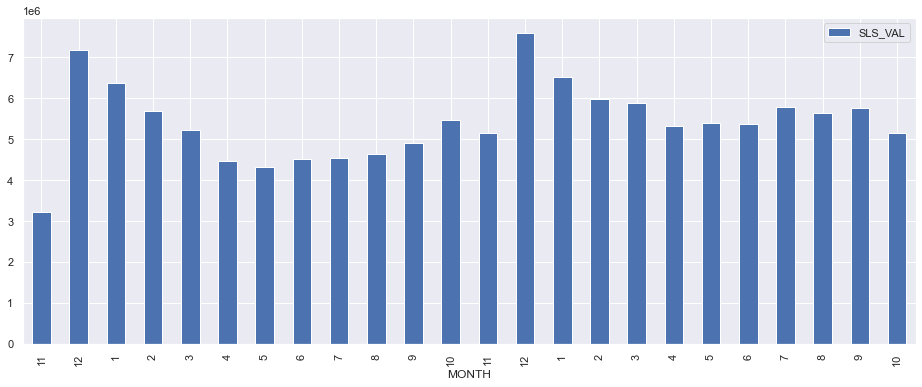

In [26]:
df1 = store_2.groupby(['YEAR','MONTH'])['SLS_VAL'].sum().reset_index()
df1.plot.bar(x='MONTH',y='SLS_VAL');

In [27]:
store_2['SKU_KEY'].nunique()

14248

In [28]:
store_2.loc[store_2['TRAN_TYPE'] == 'R', 'R'] = 1
store_2.loc[store_2['TRAN_TYPE'] != 'R', 'R'] = 0
store_2.loc[store_2['TRAN_TYPE'] == 'P', 'P'] = 1
store_2.loc[store_2['TRAN_TYPE'] != 'P', 'P'] = 0
df_sample = store_2.groupby(['SKU_KEY', 'DAY_DATE'])['R', 'P'].sum().reset_index()
df_sample['R-P'] = df_sample['R'] - df_sample['P']
df_sample.loc[df_sample['R-P'] == 0]

,SKU_KEY,DAY_DATE,R,P,R-P


## Data Cleaning

In [29]:
store_2.drop(store_2[store_2['COST_SLS_VAL']<=0].index, inplace=True)
store_2.drop(store_2[store_2['SOH_VAL']<=0].index, inplace=True)
store_2.drop(store_2[store_2['SLS_QTY']==0].index, inplace=True)
store_2.drop(store_2[store_2['SLS_VAL']==0].index, inplace=True)

In [30]:
store_2

,STORE_KEY,CITY,STATE,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,SKU_KEY,SKU_DESC,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,PZ_DESC,PZ_GROUP_DESC,SOH_QTY,SOH_VAL,R,P
1339,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,551,QUEIJO VENEZA MINAS FRESCAL LIGHT KG,PERECIVEIS,FLC,QUEIJOS,MINAS,10000.0,KG,10.0,21,1,12,R,F01 IMBITUBA,IMBITUBA,7,129,1.0,0.0
1340,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,555,PEPINO JAPONES KG,PERECIVEIS,FLV,LEGUMES,PEPINO,10000.0,KG,10.0,7,1,4,R,F01 IMBITUBA,IMBITUBA,11,31,1.0,0.0
1341,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,556,FRALDINHA BOV CECHINEL CRY KG,PERECIVEIS,CARNES,CARNE BOVINA TRASEIRO,FRALDINHA,10000.0,KG,10.0,150,7,104,R,F01 IMBITUBA,IMBITUBA,18,285,1.0,0.0
1342,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,576,MAC INST NISSIN YAKISSOBA TRAD PCT 87G,NAO PERECIVEIS,MERCEARIA,MASSAS,INSTANTANEO,870000.0,UN,10.0,3,2,2,R,F01 IMBITUBA,IMBITUBA,16,15,1.0,0.0
1343,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,581,QUEIJO VENEZA MUSSARELA FAT PCT 150G,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,1500000.0,UN,10.0,168,42,101,R,F01 IMBITUBA,IMBITUBA,1718,4144,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17926412,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,14921,SAB DOVE REVIGORANTE BR 90G,NAO PERECIVEIS,HIGIENE,SABONETE,BARRA,900000.0,UN,10.0,10,3,7,R,F01 IMBITUBA,IMBITUBA,72,159,1.0,0.0
17926415,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15726,QUEIJO DELLA VITA PRATO FAT 400G,PERECIVEIS,FLC,QUEIJOS,PRATO,4000000.0,UN,10.0,98,6,61,R,F01 IMBITUBA,IMBITUBA,201,2043,1.0,0.0
17926419,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15730,BEB LACTEA DELLA VITA MORANGO PCT 900G,PERECIVEIS,FLC,IOGURTES,BEBIDA LACTEA,9000000.0,UN,10.0,14,4,7,R,F01 IMBITUBA,IMBITUBA,18,34,1.0,0.0
17926423,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15818,FARINHA MILHO TIO MACARINI FINA PCT 1KG,NAO PERECIVEIS,MERCEARIA,FARINHAS,MILHO,10000.0,UN,10.0,4,1,3,R,F01 IMBITUBA,IMBITUBA,31,84,1.0,0.0


In [31]:
store_2['SKU_KEY'].nunique()

13612

In [32]:
store_2['SLS_VAL'].sum()

114176384

In [33]:
store_2[['SLS_VAL', 'SLS_QTY', 'COST_SLS_VAL']].describe()

,SLS_VAL,SLS_QTY,COST_SLS_VAL
count,2.681613e+06,2.681613e+06,2.681613e+06
mean,4.257750e+01,7.466590e+00,2.761488e+01
std,1.213768e+02,2.293224e+01,9.724796e+01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,8.000000e+00,1.000000e+00,4.000000e+00
50%,1.700000e+01,2.000000e+00,9.000000e+00
75%,3.600000e+01,6.000000e+00,2.000000e+01
max,1.262200e+04,4.865000e+03,2.846100e+04


# 4. New Features

## Unitátio Price

In [34]:
store_2['PRICE_UNI'] = (store_2['SLS_VAL'] / store_2['SLS_QTY']).apply(lambda x:round(x,2)) 

## Average monthly per day of the week

In [35]:
store_2['S-1'] = (store_2['DAY_DATE'] - pd.DateOffset(days=7))
store_2['S-2'] = (store_2['DAY_DATE'] - pd.DateOffset(days=14))
store_2['S-3'] = (store_2['DAY_DATE'] - pd.DateOffset(days=21))
store_2['S-4'] = (store_2['DAY_DATE'] - pd.DateOffset(days=28))

In [36]:
sample = store_2
df = store_2

In [37]:
space = '+'

In [38]:
sample["C_S-1"] = sample["S-1"].astype(str) + space + sample["SKU_KEY"].astype(str)
sample["C_S-2"] = sample["S-2"].astype(str) + space + sample["SKU_KEY"].astype(str)
sample["C_S-3"] = sample["S-3"].astype(str) + space + sample["SKU_KEY"].astype(str)
sample["C_S-4"] = sample["S-4"].astype(str) + space + sample["SKU_KEY"].astype(str)
sample_1 = sample.reset_index()
sample_1

,index,STORE_KEY,CITY,STATE,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,SKU_KEY,SKU_DESC,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,PZ_DESC,PZ_GROUP_DESC,SOH_QTY,SOH_VAL,R,P,PRICE_UNI,S-1,S-2,S-3,S-4,C_S-1,C_S-2,C_S-3,C_S-4
0,1339,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,551,QUEIJO VENEZA MINAS FRESCAL LIGHT KG,PERECIVEIS,FLC,QUEIJOS,MINAS,10000.0,KG,10.0,21,1,12,R,F01 IMBITUBA,IMBITUBA,7,129,1.0,0.0,21.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+551,2019-10-27+551,2019-10-20+551,2019-10-13+551
1,1340,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,555,PEPINO JAPONES KG,PERECIVEIS,FLV,LEGUMES,PEPINO,10000.0,KG,10.0,7,1,4,R,F01 IMBITUBA,IMBITUBA,11,31,1.0,0.0,7.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+555,2019-10-27+555,2019-10-20+555,2019-10-13+555
2,1341,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,556,FRALDINHA BOV CECHINEL CRY KG,PERECIVEIS,CARNES,CARNE BOVINA TRASEIRO,FRALDINHA,10000.0,KG,10.0,150,7,104,R,F01 IMBITUBA,IMBITUBA,18,285,1.0,0.0,21.43,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+556,2019-10-27+556,2019-10-20+556,2019-10-13+556
3,1342,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,576,MAC INST NISSIN YAKISSOBA TRAD PCT 87G,NAO PERECIVEIS,MERCEARIA,MASSAS,INSTANTANEO,870000.0,UN,10.0,3,2,2,R,F01 IMBITUBA,IMBITUBA,16,15,1.0,0.0,1.50,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+576,2019-10-27+576,2019-10-20+576,2019-10-13+576
4,1343,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,581,QUEIJO VENEZA MUSSARELA FAT PCT 150G,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,1500000.0,UN,10.0,168,42,101,R,F01 IMBITUBA,IMBITUBA,1718,4144,1.0,0.0,4.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+581,2019-10-27+581,2019-10-20+581,2019-10-13+581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681608,17926412,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,14921,SAB DOVE REVIGORANTE BR 90G,NAO PERECIVEIS,HIGIENE,SABONETE,BARRA,900000.0,UN,10.0,10,3,7,R,F01 IMBITUBA,IMBITUBA,72,159,1.0,0.0,3.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+14921,2021-10-13+14921,2021-10-06+14921,2021-09-29+14921
2681609,17926415,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15726,QUEIJO DELLA VITA PRATO FAT 400G,PERECIVEIS,FLC,QUEIJOS,PRATO,4000000.0,UN,10.0,98,6,61,R,F01 IMBITUBA,IMBITUBA,201,2043,1.0,0.0,16.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15726,2021-10-13+15726,2021-10-06+15726,2021-09-29+15726
2681610,17926419,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15730,BEB LACTEA DELLA VITA MORANGO PCT 900G,PERECIVEIS,FLC,IOGURTES,BEBIDA LACTEA,9000000.0,UN,10.0,14,4,7,R,F01 IMBITUBA,IMBITUBA,18,34,1.0,0.0,3.50,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15730,2021-10-13+15730,2021-10-06+15730,2021-09-29+15730
2681611,17926423,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15818,FARINHA MILHO TIO MACARINI FINA PCT 1KG,NAO PERECIVEIS,MERCEARIA,FARINHAS,MILHO,10000.0,UN,10.0,4,1,3,R,F01 IMBITUBA,IMBITUBA,31,84,1.0,0.0,4.00,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15818,2021-10-13+15818,2021-10-06+15818,2021-09-29+15818


In [39]:
df["C_S-1"] = df["DAY_DATE"].astype(str) + space + df["SKU_KEY"].astype(str)
df["C_S-2"] = df["DAY_DATE"].astype(str) + space + df["SKU_KEY"].astype(str)
df["C_S-3"] = df["DAY_DATE"].astype(str) + space + df["SKU_KEY"].astype(str)
df["C_S-4"] = df["DAY_DATE"].astype(str) + space + df["SKU_KEY"].astype(str)
df["QTY_1"] = df["SLS_QTY"]
df["QTY_2"] = df["SLS_QTY"]
df["QTY_3"] = df["SLS_QTY"]
df["QTY_4"] = df["SLS_QTY"]
df_1 = df.reset_index()
df_1

,index,STORE_KEY,CITY,STATE,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,SKU_KEY,SKU_DESC,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,PZ_DESC,PZ_GROUP_DESC,SOH_QTY,SOH_VAL,R,P,PRICE_UNI,S-1,S-2,S-3,S-4,C_S-1,C_S-2,C_S-3,C_S-4,QTY_1,QTY_2,QTY_3,QTY_4
0,1339,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,551,QUEIJO VENEZA MINAS FRESCAL LIGHT KG,PERECIVEIS,FLC,QUEIJOS,MINAS,10000.0,KG,10.0,21,1,12,R,F01 IMBITUBA,IMBITUBA,7,129,1.0,0.0,21.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-10+551,2019-11-10+551,2019-11-10+551,2019-11-10+551,1,1,1,1
1,1340,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,555,PEPINO JAPONES KG,PERECIVEIS,FLV,LEGUMES,PEPINO,10000.0,KG,10.0,7,1,4,R,F01 IMBITUBA,IMBITUBA,11,31,1.0,0.0,7.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-10+555,2019-11-10+555,2019-11-10+555,2019-11-10+555,1,1,1,1
2,1341,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,556,FRALDINHA BOV CECHINEL CRY KG,PERECIVEIS,CARNES,CARNE BOVINA TRASEIRO,FRALDINHA,10000.0,KG,10.0,150,7,104,R,F01 IMBITUBA,IMBITUBA,18,285,1.0,0.0,21.43,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-10+556,2019-11-10+556,2019-11-10+556,2019-11-10+556,7,7,7,7
3,1342,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,576,MAC INST NISSIN YAKISSOBA TRAD PCT 87G,NAO PERECIVEIS,MERCEARIA,MASSAS,INSTANTANEO,870000.0,UN,10.0,3,2,2,R,F01 IMBITUBA,IMBITUBA,16,15,1.0,0.0,1.50,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-10+576,2019-11-10+576,2019-11-10+576,2019-11-10+576,2,2,2,2
4,1343,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,581,QUEIJO VENEZA MUSSARELA FAT PCT 150G,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,1500000.0,UN,10.0,168,42,101,R,F01 IMBITUBA,IMBITUBA,1718,4144,1.0,0.0,4.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,42,42,42,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681608,17926412,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,14921,SAB DOVE REVIGORANTE BR 90G,NAO PERECIVEIS,HIGIENE,SABONETE,BARRA,900000.0,UN,10.0,10,3,7,R,F01 IMBITUBA,IMBITUBA,72,159,1.0,0.0,3.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-27+14921,2021-10-27+14921,2021-10-27+14921,2021-10-27+14921,3,3,3,3
2681609,17926415,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15726,QUEIJO DELLA VITA PRATO FAT 400G,PERECIVEIS,FLC,QUEIJOS,PRATO,4000000.0,UN,10.0,98,6,61,R,F01 IMBITUBA,IMBITUBA,201,2043,1.0,0.0,16.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-27+15726,2021-10-27+15726,2021-10-27+15726,2021-10-27+15726,6,6,6,6
2681610,17926419,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15730,BEB LACTEA DELLA VITA MORANGO PCT 900G,PERECIVEIS,FLC,IOGURTES,BEBIDA LACTEA,9000000.0,UN,10.0,14,4,7,R,F01 IMBITUBA,IMBITUBA,18,34,1.0,0.0,3.50,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-27+15730,2021-10-27+15730,2021-10-27+15730,2021-10-27+15730,4,4,4,4
2681611,17926423,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15818,FARINHA MILHO TIO MACARINI FINA PCT 1KG,NAO PERECIVEIS,MERCEARIA,FARINHAS,MILHO,10000.0,UN,10.0,4,1,3,R,F01 IMBITUBA,IMBITUBA,31,84,1.0,0.0,4.00,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-27+15818,2021-10-27+15818,2021-10-27+15818,2021-10-27+15818,1,1,1,1


In [40]:
df_2 = df_1[['C_S-1', 'QTY_1']]
df_3 = df_1[['C_S-2', 'QTY_2']]
df_4 = df_1[['C_S-3', 'QTY_3']]
df_5 = df_1[['C_S-4', 'QTY_4']]

In [41]:
join_sample = pd.merge(sample_1,df_2,how='left',on='C_S-1')
join_sample_1 = pd.merge(join_sample,df_3,how='left',on='C_S-2')
join_sample_2 = pd.merge(join_sample_1,df_4,how='left',on='C_S-3')
join_sample_3 = pd.merge(join_sample_2,df_5,how='left',on='C_S-4')

In [42]:
join_sample_3

,index,STORE_KEY,CITY,STATE,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,SKU_KEY,SKU_DESC,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,PZ_DESC,PZ_GROUP_DESC,SOH_QTY,SOH_VAL,R,P,PRICE_UNI,S-1,S-2,S-3,S-4,C_S-1,C_S-2,C_S-3,C_S-4,QTY_1,QTY_2,QTY_3,QTY_4
0,1339,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,551,QUEIJO VENEZA MINAS FRESCAL LIGHT KG,PERECIVEIS,FLC,QUEIJOS,MINAS,10000.0,KG,10.0,21,1,12,R,F01 IMBITUBA,IMBITUBA,7,129,1.0,0.0,21.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+551,2019-10-27+551,2019-10-20+551,2019-10-13+551,NaN,NaN,NaN,NaN
1,1340,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,555,PEPINO JAPONES KG,PERECIVEIS,FLV,LEGUMES,PEPINO,10000.0,KG,10.0,7,1,4,R,F01 IMBITUBA,IMBITUBA,11,31,1.0,0.0,7.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+555,2019-10-27+555,2019-10-20+555,2019-10-13+555,NaN,NaN,NaN,NaN
2,1341,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,556,FRALDINHA BOV CECHINEL CRY KG,PERECIVEIS,CARNES,CARNE BOVINA TRASEIRO,FRALDINHA,10000.0,KG,10.0,150,7,104,R,F01 IMBITUBA,IMBITUBA,18,285,1.0,0.0,21.43,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+556,2019-10-27+556,2019-10-20+556,2019-10-13+556,NaN,NaN,NaN,NaN
3,1342,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,576,MAC INST NISSIN YAKISSOBA TRAD PCT 87G,NAO PERECIVEIS,MERCEARIA,MASSAS,INSTANTANEO,870000.0,UN,10.0,3,2,2,R,F01 IMBITUBA,IMBITUBA,16,15,1.0,0.0,1.50,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+576,2019-10-27+576,2019-10-20+576,2019-10-13+576,NaN,NaN,NaN,NaN
4,1343,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,581,QUEIJO VENEZA MUSSARELA FAT PCT 150G,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,1500000.0,UN,10.0,168,42,101,R,F01 IMBITUBA,IMBITUBA,1718,4144,1.0,0.0,4.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+581,2019-10-27+581,2019-10-20+581,2019-10-13+581,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681608,17926412,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,14921,SAB DOVE REVIGORANTE BR 90G,NAO PERECIVEIS,HIGIENE,SABONETE,BARRA,900000.0,UN,10.0,10,3,7,R,F01 IMBITUBA,IMBITUBA,72,159,1.0,0.0,3.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+14921,2021-10-13+14921,2021-10-06+14921,2021-09-29+14921,2.0,6.0,9.0,4.0
2681609,17926415,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15726,QUEIJO DELLA VITA PRATO FAT 400G,PERECIVEIS,FLC,QUEIJOS,PRATO,4000000.0,UN,10.0,98,6,61,R,F01 IMBITUBA,IMBITUBA,201,2043,1.0,0.0,16.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15726,2021-10-13+15726,2021-10-06+15726,2021-09-29+15726,3.0,3.0,6.0,4.0
2681610,17926419,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15730,BEB LACTEA DELLA VITA MORANGO PCT 900G,PERECIVEIS,FLC,IOGURTES,BEBIDA LACTEA,9000000.0,UN,10.0,14,4,7,R,F01 IMBITUBA,IMBITUBA,18,34,1.0,0.0,3.50,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15730,2021-10-13+15730,2021-10-06+15730,2021-09-29+15730,7.0,4.0,2.0,7.0
2681611,17926423,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15818,FARINHA MILHO TIO MACARINI FINA PCT 1KG,NAO PERECIVEIS,MERCEARIA,FARINHAS,MILHO,10000.0,UN,10.0,4,1,3,R,F01 IMBITUBA,IMBITUBA,31,84,1.0,0.0,4.00,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15818,2021-10-13+15818,2021-10-06+15818,2021-09-29+15818,NaN,NaN,NaN,1.0


In [43]:
new_sample = join_sample_3
new_sample = new_sample.fillna(0)
new_sample['MEAN_QTY'] = (new_sample['QTY_1'] + new_sample['QTY_2'] + new_sample['QTY_3'] + new_sample['QTY_4']) / 4
new_sample

,index,STORE_KEY,CITY,STATE,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,SKU_KEY,SKU_DESC,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,PZ_DESC,PZ_GROUP_DESC,SOH_QTY,SOH_VAL,R,P,PRICE_UNI,S-1,S-2,S-3,S-4,C_S-1,C_S-2,C_S-3,C_S-4,QTY_1,QTY_2,QTY_3,QTY_4,MEAN_QTY
0,1339,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,551,QUEIJO VENEZA MINAS FRESCAL LIGHT KG,PERECIVEIS,FLC,QUEIJOS,MINAS,10000.0,KG,10.0,21,1,12,R,F01 IMBITUBA,IMBITUBA,7,129,1.0,0.0,21.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+551,2019-10-27+551,2019-10-20+551,2019-10-13+551,0.0,0.0,0.0,0.0,0.00
1,1340,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,555,PEPINO JAPONES KG,PERECIVEIS,FLV,LEGUMES,PEPINO,10000.0,KG,10.0,7,1,4,R,F01 IMBITUBA,IMBITUBA,11,31,1.0,0.0,7.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+555,2019-10-27+555,2019-10-20+555,2019-10-13+555,0.0,0.0,0.0,0.0,0.00
2,1341,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,556,FRALDINHA BOV CECHINEL CRY KG,PERECIVEIS,CARNES,CARNE BOVINA TRASEIRO,FRALDINHA,10000.0,KG,10.0,150,7,104,R,F01 IMBITUBA,IMBITUBA,18,285,1.0,0.0,21.43,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+556,2019-10-27+556,2019-10-20+556,2019-10-13+556,0.0,0.0,0.0,0.0,0.00
3,1342,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,576,MAC INST NISSIN YAKISSOBA TRAD PCT 87G,NAO PERECIVEIS,MERCEARIA,MASSAS,INSTANTANEO,870000.0,UN,10.0,3,2,2,R,F01 IMBITUBA,IMBITUBA,16,15,1.0,0.0,1.50,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+576,2019-10-27+576,2019-10-20+576,2019-10-13+576,0.0,0.0,0.0,0.0,0.00
4,1343,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,581,QUEIJO VENEZA MUSSARELA FAT PCT 150G,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,1500000.0,UN,10.0,168,42,101,R,F01 IMBITUBA,IMBITUBA,1718,4144,1.0,0.0,4.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+581,2019-10-27+581,2019-10-20+581,2019-10-13+581,0.0,0.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681608,17926412,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,14921,SAB DOVE REVIGORANTE BR 90G,NAO PERECIVEIS,HIGIENE,SABONETE,BARRA,900000.0,UN,10.0,10,3,7,R,F01 IMBITUBA,IMBITUBA,72,159,1.0,0.0,3.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+14921,2021-10-13+14921,2021-10-06+14921,2021-09-29+14921,2.0,6.0,9.0,4.0,5.25
2681609,17926415,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15726,QUEIJO DELLA VITA PRATO FAT 400G,PERECIVEIS,FLC,QUEIJOS,PRATO,4000000.0,UN,10.0,98,6,61,R,F01 IMBITUBA,IMBITUBA,201,2043,1.0,0.0,16.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15726,2021-10-13+15726,2021-10-06+15726,2021-09-29+15726,3.0,3.0,6.0,4.0,4.00
2681610,17926419,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15730,BEB LACTEA DELLA VITA MORANGO PCT 900G,PERECIVEIS,FLC,IOGURTES,BEBIDA LACTEA,9000000.0,UN,10.0,14,4,7,R,F01 IMBITUBA,IMBITUBA,18,34,1.0,0.0,3.50,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15730,2021-10-13+15730,2021-10-06+15730,2021-09-29+15730,7.0,4.0,2.0,7.0,5.00
2681611,17926423,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15818,FARINHA MILHO TIO MACARINI FINA PCT 1KG,NAO PERECIVEIS,MERCEARIA,FARINHAS,MILHO,10000.0,UN,10.0,4,1,3,R,F01 IMBITUBA,IMBITUBA,31,84,1.0,0.0,4.00,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15818,2021-10-13+15818,2021-10-06+15818,2021-09-29+15818,0.0,0.0,0.0,1.0,0.25


## Average per month

In [44]:
new_sample.loc[(new_sample['MONTH'] - 1) == 0, 'M-1'] = 12
new_sample.loc[(new_sample['MONTH'] - 1) > 0, 'M-1'] = (new_sample['MONTH'] - 1)
new_sample.loc[(new_sample['MONTH'] - 1) == 0, 'Y-1'] = (new_sample['YEAR'] - 1)
new_sample.loc[(new_sample['MONTH'] - 1) > 0, 'Y-1'] = new_sample['YEAR']

new_sample.loc[(new_sample['M-1'] - 1) == 0, 'M-2'] = 12
new_sample.loc[(new_sample['M-1'] - 1) > 0, 'M-2'] = (new_sample['M-1'] - 1)
new_sample.loc[(new_sample['M-1'] - 1) == 0, 'Y-2'] = (new_sample['Y-1'] - 1)
new_sample.loc[(new_sample['M-1'] - 1) > 0, 'Y-2'] = new_sample['Y-1']

new_sample.loc[(new_sample['M-2'] - 1) == 0, 'M-3'] = 12
new_sample.loc[(new_sample['M-2'] - 1) > 0, 'M-3'] = (new_sample['M-2'] - 1)
new_sample.loc[(new_sample['M-2'] - 1) == 0, 'Y-3'] = (new_sample['Y-2'] - 1)
new_sample.loc[(new_sample['M-2'] - 1) > 0, 'Y-3'] = new_sample['Y-2'] 

new_sample.loc[(new_sample['M-3'] - 1) == 0, 'M-4'] = 12
new_sample.loc[(new_sample['M-3'] - 1) > 0, 'M-4'] = (new_sample['M-3'] - 1)
new_sample.loc[(new_sample['M-3'] - 1) == 0, 'Y-4'] = (new_sample['Y-3'] - 1)
new_sample.loc[(new_sample['M-3'] - 1) > 0, 'Y-4'] = new_sample['Y-3']

new_sample.loc[(new_sample['M-4'] - 1) == 0, 'M-5'] = 12
new_sample.loc[(new_sample['M-4'] - 1) > 0, 'M-5'] = (new_sample['M-4'] - 1)
new_sample.loc[(new_sample['M-4'] - 1) == 0, 'Y-5'] = (new_sample['Y-4'] - 1)
new_sample.loc[(new_sample['M-4'] - 1) > 0, 'Y-5'] = new_sample['Y-4']

new_sample.loc[(new_sample['M-5'] - 1) == 0, 'M-6'] = 12
new_sample.loc[(new_sample['M-5'] - 1) > 0, 'M-6'] = (new_sample['M-5'] - 1)
new_sample.loc[(new_sample['M-5'] - 1) == 0, 'Y-6'] = (new_sample['Y-5'] - 1) 
new_sample.loc[(new_sample['M-5'] - 1) > 0, 'Y-6'] = new_sample['Y-5']

new_sample.loc[(new_sample['M-6'] - 1) == 0, 'M-7'] = 12
new_sample.loc[(new_sample['M-6'] - 1) > 0, 'M-7'] = (new_sample['M-6'] - 1)
new_sample.loc[(new_sample['M-6'] - 1) == 0, 'Y-7'] = (new_sample['Y-6'] - 1)
new_sample.loc[(new_sample['M-6'] - 1) > 0, 'Y-7'] = new_sample['Y-6']

new_sample.loc[(new_sample['M-7'] - 1) == 0, 'M-8'] = 12
new_sample.loc[(new_sample['M-7'] - 1) > 0, 'M-8'] = (new_sample['M-7'] - 1) 
new_sample.loc[(new_sample['M-7'] - 1) == 0, 'Y-8'] = (new_sample['Y-7'] - 1) 
new_sample.loc[(new_sample['M-7'] - 1) > 0, 'Y-8'] = new_sample['Y-7']

new_sample.loc[(new_sample['M-8'] - 1) == 0, 'M-9'] = 12
new_sample.loc[(new_sample['M-8'] - 1) > 0, 'M-9'] = (new_sample['M-8'] - 1)
new_sample.loc[(new_sample['M-8'] - 1) == 0, 'Y-9'] = (new_sample['Y-8'] - 1)
new_sample.loc[(new_sample['M-8'] - 1) > 0, 'Y-9'] = new_sample['Y-8']

new_sample.loc[(new_sample['M-9'] - 1) == 0, 'M-10'] = 12
new_sample.loc[(new_sample['M-9'] - 1) > 0, 'M-10'] = (new_sample['M-9'] - 1)
new_sample.loc[(new_sample['M-9'] - 1) == 0, 'Y-10'] = (new_sample['Y-9'] - 1) 
new_sample.loc[(new_sample['M-9'] - 1) > 0, 'Y-10'] = new_sample['Y-9'] 

new_sample.loc[(new_sample['M-10'] - 1) == 0, 'M-11'] = 12
new_sample.loc[(new_sample['M-10'] - 1) > 0, 'M-11'] = (new_sample['M-10'] - 1)
new_sample.loc[(new_sample['M-10'] - 1) == 0, 'Y-11'] = (new_sample['Y-10'] - 1)
new_sample.loc[(new_sample['M-10'] - 1) > 0, 'Y-11'] = new_sample['Y-10'] 

new_sample.loc[(new_sample['M-11'] - 1) == 0, 'M-12'] = 12
new_sample.loc[(new_sample['M-11'] - 1) > 0, 'M-12'] = (new_sample['M-11'] - 1) 
new_sample.loc[(new_sample['M-11'] - 1) == 0, 'Y-12'] = (new_sample['Y-11'] - 1)
new_sample.loc[(new_sample['M-11'] - 1) > 0, 'Y-12'] = new_sample['Y-11']

In [45]:
new_sample['M-1'] = pd.to_numeric(new_sample['M-1'], downcast='integer')
new_sample['M-2'] = pd.to_numeric(new_sample['M-2'], downcast='integer')
new_sample['M-3'] = pd.to_numeric(new_sample['M-3'], downcast='integer')
new_sample['M-4'] = pd.to_numeric(new_sample['M-4'], downcast='integer')
new_sample['M-5'] = pd.to_numeric(new_sample['M-5'], downcast='integer')
new_sample['M-6'] = pd.to_numeric(new_sample['M-6'], downcast='integer')
new_sample['M-7'] = pd.to_numeric(new_sample['M-7'], downcast='integer')
new_sample['M-8'] = pd.to_numeric(new_sample['M-8'], downcast='integer')
new_sample['M-9'] = pd.to_numeric(new_sample['M-9'], downcast='integer')
new_sample['M-10'] = pd.to_numeric(new_sample['M-10'], downcast='integer')
new_sample['M-11'] = pd.to_numeric(new_sample['M-11'], downcast='integer')
new_sample['M-12'] = pd.to_numeric(new_sample['M-12'], downcast='integer')

new_sample['Y-1'] = pd.to_numeric(new_sample['Y-1'], downcast='integer')
new_sample['Y-2'] = pd.to_numeric(new_sample['Y-2'], downcast='integer')
new_sample['Y-3'] = pd.to_numeric(new_sample['Y-3'], downcast='integer')
new_sample['Y-4'] = pd.to_numeric(new_sample['Y-4'], downcast='integer')
new_sample['Y-5'] = pd.to_numeric(new_sample['Y-5'], downcast='integer')
new_sample['Y-6'] = pd.to_numeric(new_sample['Y-6'], downcast='integer')
new_sample['Y-7'] = pd.to_numeric(new_sample['Y-7'], downcast='integer')
new_sample['Y-8'] = pd.to_numeric(new_sample['Y-8'], downcast='integer')
new_sample['Y-9'] = pd.to_numeric(new_sample['Y-9'], downcast='integer')
new_sample['Y-10'] = pd.to_numeric(new_sample['Y-10'], downcast='integer')
new_sample['Y-11'] = pd.to_numeric(new_sample['Y-11'], downcast='integer')
new_sample['Y-12'] = pd.to_numeric(new_sample['Y-12'], downcast='integer')

In [46]:
new_sample

,index,STORE_KEY,CITY,STATE,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,SKU_KEY,SKU_DESC,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,PACKAGE_SIZE,PACKAGE_UOM,PACKAGE_NO_UNITS,SLS_VAL,SLS_QTY,COST_SLS_VAL,TRAN_TYPE,PZ_DESC,PZ_GROUP_DESC,SOH_QTY,SOH_VAL,R,P,PRICE_UNI,S-1,S-2,S-3,S-4,C_S-1,C_S-2,C_S-3,C_S-4,QTY_1,QTY_2,QTY_3,QTY_4,MEAN_QTY,M-1,Y-1,M-2,Y-2,M-3,Y-3,M-4,Y-4,M-5,Y-5,M-6,Y-6,M-7,Y-7,M-8,Y-8,M-9,Y-9,M-10,Y-10,M-11,Y-11,M-12,Y-12
0,1339,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,551,QUEIJO VENEZA MINAS FRESCAL LIGHT KG,PERECIVEIS,FLC,QUEIJOS,MINAS,10000.0,KG,10.0,21,1,12,R,F01 IMBITUBA,IMBITUBA,7,129,1.0,0.0,21.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+551,2019-10-27+551,2019-10-20+551,2019-10-13+551,0.0,0.0,0.0,0.0,0.00,10,2019,9,2019,8,2019,7,2019,6,2019,5,2019,4,2019,3,2019,2,2019,1,2019,12,2018,11,2018
1,1340,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,555,PEPINO JAPONES KG,PERECIVEIS,FLV,LEGUMES,PEPINO,10000.0,KG,10.0,7,1,4,R,F01 IMBITUBA,IMBITUBA,11,31,1.0,0.0,7.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+555,2019-10-27+555,2019-10-20+555,2019-10-13+555,0.0,0.0,0.0,0.0,0.00,10,2019,9,2019,8,2019,7,2019,6,2019,5,2019,4,2019,3,2019,2,2019,1,2019,12,2018,11,2018
2,1341,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,556,FRALDINHA BOV CECHINEL CRY KG,PERECIVEIS,CARNES,CARNE BOVINA TRASEIRO,FRALDINHA,10000.0,KG,10.0,150,7,104,R,F01 IMBITUBA,IMBITUBA,18,285,1.0,0.0,21.43,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+556,2019-10-27+556,2019-10-20+556,2019-10-13+556,0.0,0.0,0.0,0.0,0.00,10,2019,9,2019,8,2019,7,2019,6,2019,5,2019,4,2019,3,2019,2,2019,1,2019,12,2018,11,2018
3,1342,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,576,MAC INST NISSIN YAKISSOBA TRAD PCT 87G,NAO PERECIVEIS,MERCEARIA,MASSAS,INSTANTANEO,870000.0,UN,10.0,3,2,2,R,F01 IMBITUBA,IMBITUBA,16,15,1.0,0.0,1.50,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+576,2019-10-27+576,2019-10-20+576,2019-10-13+576,0.0,0.0,0.0,0.0,0.00,10,2019,9,2019,8,2019,7,2019,6,2019,5,2019,4,2019,3,2019,2,2019,1,2019,12,2018,11,2018
4,1343,2,IMBITUBA,SC,2019-11-10,2019,11,10,45,6,581,QUEIJO VENEZA MUSSARELA FAT PCT 150G,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,1500000.0,UN,10.0,168,42,101,R,F01 IMBITUBA,IMBITUBA,1718,4144,1.0,0.0,4.00,2019-11-03,2019-10-27,2019-10-20,2019-10-13,2019-11-03+581,2019-10-27+581,2019-10-20+581,2019-10-13+581,0.0,0.0,0.0,0.0,0.00,10,2019,9,2019,8,2019,7,2019,6,2019,5,2019,4,2019,3,2019,2,2019,1,2019,12,2018,11,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681608,17926412,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,14921,SAB DOVE REVIGORANTE BR 90G,NAO PERECIVEIS,HIGIENE,SABONETE,BARRA,900000.0,UN,10.0,10,3,7,R,F01 IMBITUBA,IMBITUBA,72,159,1.0,0.0,3.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+14921,2021-10-13+14921,2021-10-06+14921,2021-09-29+14921,2.0,6.0,9.0,4.0,5.25,9,2021,8,2021,7,2021,6,2021,5,2021,4,2021,3,2021,2,2021,1,2021,12,2020,11,2020,10,2020
2681609,17926415,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15726,QUEIJO DELLA VITA PRATO FAT 400G,PERECIVEIS,FLC,QUEIJOS,PRATO,4000000.0,UN,10.0,98,6,61,R,F01 IMBITUBA,IMBITUBA,201,2043,1.0,0.0,16.33,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15726,2021-10-13+15726,2021-10-06+15726,2021-09-29+15726,3.0,3.0,6.0,4.0,4.00,9,2021,8,2021,7,2021,6,2021,5,2021,4,2021,3,2021,2,2021,1,2021,12,2020,11,2020,10,2020
2681610,17926419,2,IMBITUBA,SC,2021-10-27,2021,10,27,43,2,15730,BEB LACTEA DELLA VITA MORANGO PCT 900G,PERECIVEIS,FLC,IOGURTES,BEBIDA LACTEA,9000000.0,UN,10.0,14,4,7,R,F01 IMBITUBA,IMBITUBA,18,34,1.0,0.0,3.50,2021-10-20,2021-10-13,2021-10-06,2021-09-29,2021-10-20+15730,2021-10-13+15730,2021-10-06+15730,2021-09-29+15730,7.0,4.0,2.0,7.0,5.00,9,2021,8,2021,7,2021,6,2021,5,2021,4,2021,3,2021,2,2021,1,2021,12,2020,11,2020,

In [47]:
new_sample["CONCAT_M-1"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-1"].astype(str) + space + new_sample["M-1"].astype(str)
new_sample["CONCAT_M-2"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-2"].astype(str) + space + new_sample["M-2"].astype(str)
new_sample["CONCAT_M-3"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-3"].astype(str) + space + new_sample["M-3"].astype(str)
new_sample["CONCAT_M-4"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-4"].astype(str) + space + new_sample["M-4"].astype(str)
new_sample["CONCAT_M-5"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-5"].astype(str) + space + new_sample["M-5"].astype(str)
new_sample["CONCAT_M-6"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-6"].astype(str) + space + new_sample["M-6"].astype(str)
new_sample["CONCAT_M-7"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-7"].astype(str) + space + new_sample["M-7"].astype(str)
new_sample["CONCAT_M-8"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-8"].astype(str) + space + new_sample["M-8"].astype(str)
new_sample["CONCAT_M-9"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-9"].astype(str) + space + new_sample["M-9"].astype(str)
new_sample["CONCAT_M-10"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-10"].astype(str) + space + new_sample["M-10"].astype(str)
new_sample["CONCAT_M-11"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-11"].astype(str) + space + new_sample["M-11"].astype(str)
new_sample["CONCAT_M-12"] = new_sample["SKU_KEY"].astype(str) + space + new_sample["Y-12"].astype(str) + space + new_sample["M-12"].astype(str)

In [48]:
MEAN_QTY_MONTH = new_sample.groupby(['SKU_KEY', 'YEAR', 'MONTH'])['SLS_QTY'].mean().round(0).astype(int).reset_index()

In [49]:
MEAN_QTY_MONTH["CONCAT"] = MEAN_QTY_MONTH["SKU_KEY"].astype(str) + space + MEAN_QTY_MONTH["YEAR"].astype(str) + space + MEAN_QTY_MONTH["MONTH"].astype(str)

In [50]:
MEAN_QTY_MONTH["CONCAT_M-1"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-2"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-3"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-4"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-5"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-6"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-7"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-8"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-9"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-10"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-11"] = MEAN_QTY_MONTH["CONCAT"]
MEAN_QTY_MONTH["CONCAT_M-12"] = MEAN_QTY_MONTH["CONCAT"]

MEAN_QTY_MONTH["QTY_M-1"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-2"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-3"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-4"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-5"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-6"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-7"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-8"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-9"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-10"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-11"] = MEAN_QTY_MONTH["SLS_QTY"]
MEAN_QTY_MONTH["QTY_M-12"] = MEAN_QTY_MONTH["SLS_QTY"]

In [51]:
df_M1 =  MEAN_QTY_MONTH[["CONCAT_M-1", "QTY_M-1"]]
df_M2 =  MEAN_QTY_MONTH[["CONCAT_M-2", "QTY_M-2"]]
df_M3 =  MEAN_QTY_MONTH[["CONCAT_M-3", "QTY_M-3"]]
df_M4 =  MEAN_QTY_MONTH[["CONCAT_M-4", "QTY_M-4"]]
df_M5 =  MEAN_QTY_MONTH[["CONCAT_M-5", "QTY_M-5"]]
df_M6 =  MEAN_QTY_MONTH[["CONCAT_M-6", "QTY_M-6"]]
df_M7 =  MEAN_QTY_MONTH[["CONCAT_M-7", "QTY_M-7"]]
df_M8 =  MEAN_QTY_MONTH[["CONCAT_M-8", "QTY_M-8"]]
df_M9 =  MEAN_QTY_MONTH[["CONCAT_M-9", "QTY_M-9"]]
df_M10 =  MEAN_QTY_MONTH[["CONCAT_M-10", "QTY_M-10"]]
df_M11 =  MEAN_QTY_MONTH[["CONCAT_M-11", "QTY_M-11"]]
df_M12 =  MEAN_QTY_MONTH[["CONCAT_M-12", "QTY_M-12"]]

In [52]:
join_M1 = pd.merge(new_sample,df_M1, how='left',on='CONCAT_M-1')
join_M2 = pd.merge(join_M1,df_M2, how='left',on='CONCAT_M-2')
join_M3 = pd.merge(join_M2,df_M3, how='left',on='CONCAT_M-3')
join_M4 = pd.merge(join_M3,df_M4, how='left',on='CONCAT_M-4')
join_M5 = pd.merge(join_M4,df_M5, how='left',on='CONCAT_M-5')
join_M6 = pd.merge(join_M5,df_M6, how='left',on='CONCAT_M-6')
join_M7 = pd.merge(join_M6,df_M7, how='left',on='CONCAT_M-7')
join_M8 = pd.merge(join_M7,df_M8, how='left',on='CONCAT_M-8')
join_M9 = pd.merge(join_M8,df_M9, how='left',on='CONCAT_M-9')
join_M10 = pd.merge(join_M9,df_M10, how='left',on='CONCAT_M-10')
join_M11 = pd.merge(join_M10,df_M11, how='left',on='CONCAT_M-11')
join_M12 = pd.merge(join_M11,df_M12, how='left',on='CONCAT_M-12')

In [53]:
new_sample_df = join_M12
new_sample_df = new_sample_df.fillna(0)

In [54]:
new_sample_df = new_sample_df[['SKU_KEY', 'SLS_VAL', 'SLS_QTY', 'TRAN_TYPE', 'MERCH_L2_DESC','MERCH_L3_DESC', 'MERCH_L4_DESC', 'MERCH_L5_DESC', 'DAY_DATE', 'YEAR', 'MONTH', 'DAY', 'WEEK_NUMBER', 'DAY_OF_WEEK','MEAN_QTY','QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PRICE_UNI']]

## Outlier Detection

In [55]:
new_sample_df['%_QTY'] = (new_sample_df['SLS_QTY'] - new_sample_df['MEAN_QTY']) / new_sample_df['MEAN_QTY']
new_sample_df = new_sample_df.replace([np.inf, -np.inf], np.nan)

In [56]:
split_date_1 ='2020-07-27'
split_date_2 ='2021-07-28'
df_training = new_sample_df.loc[(new_sample_df['DAY_DATE'] >= split_date_1) & (new_sample_df['DAY_DATE'] < split_date_2)]
df_test = new_sample_df.loc[(new_sample_df['DAY_DATE'] >= split_date_2)]

In [57]:
len(df_test) / len(df_training) * 100

24.48850113136692

In [58]:
new_sample_df = new_sample_df.fillna(0)
new_sample_df['%_QTY'] = new_sample_df['%_QTY'].apply(lambda x:round(x,2))
new_sample_df

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,%_QTY
0,551,21,1,R,PERECIVEIS,FLC,QUEIJOS,MINAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.00,0.00
1,555,7,1,R,PERECIVEIS,FLV,LEGUMES,PEPINO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0.00
2,556,150,7,R,PERECIVEIS,CARNES,CARNE BOVINA TRASEIRO,FRALDINHA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.43,0.00
3,576,3,2,R,NAO PERECIVEIS,MERCEARIA,MASSAS,INSTANTANEO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.50,0.00
4,581,168,42,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681608,14921,10,3,R,NAO PERECIVEIS,HIGIENE,SABONETE,BARRA,2021-10-27,2021,10,27,43,2,5.25,5.0,6.0,4.0,0.0,0.0,5.0,6.0,6.0,6.0,7.0,8.0,8.0,3.33,-0.43
2681609,15726,98,6,R,PERECIVEIS,FLC,QUEIJOS,PRATO,2021-10-27,2021,10,27,43,2,4.00,7.0,11.0,15.0,16.0,10.0,12.0,16.0,17.0,22.0,11.0,7.0,7.0,16.33,0.50
2681610,15730,14,4,R,PERECIVEIS,FLC,IOGURTES,BEBIDA LACTEA,2021-10-27,2021,10,27,43,2,5.00,10.0,4.0,3.0,3.0,3.0,4.0,5.0,6.0,4.0,6.0,5.0,4.0,3.50,-0.20
2681611,15818,4,1,R,NAO PERECIVEIS,MERCEARIA,FARINHAS,MILHO,2021-10-27,2021,10,27,43,2,0.25,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.00,3.00


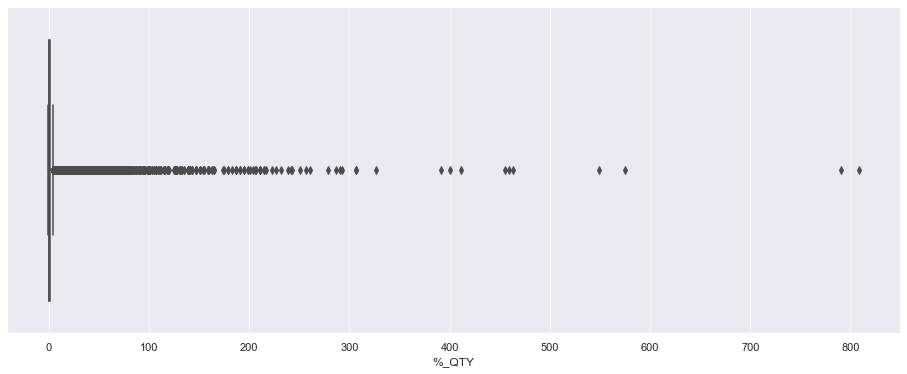

In [59]:
sns.boxplot(df_training['%_QTY']);

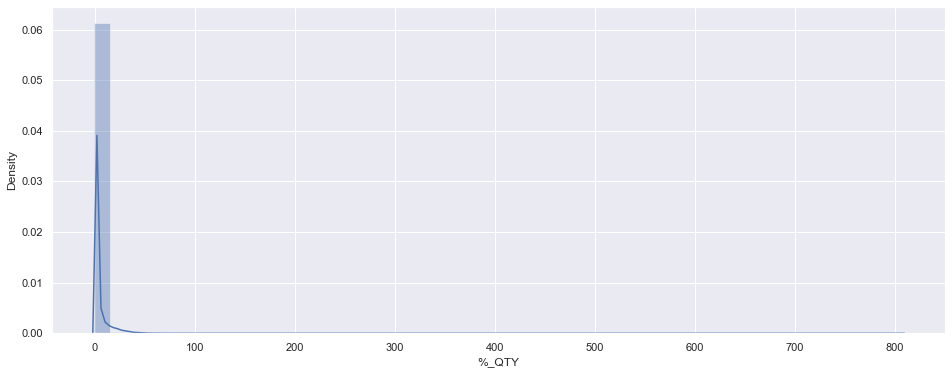

In [60]:
sns.distplot(df_training['%_QTY']);

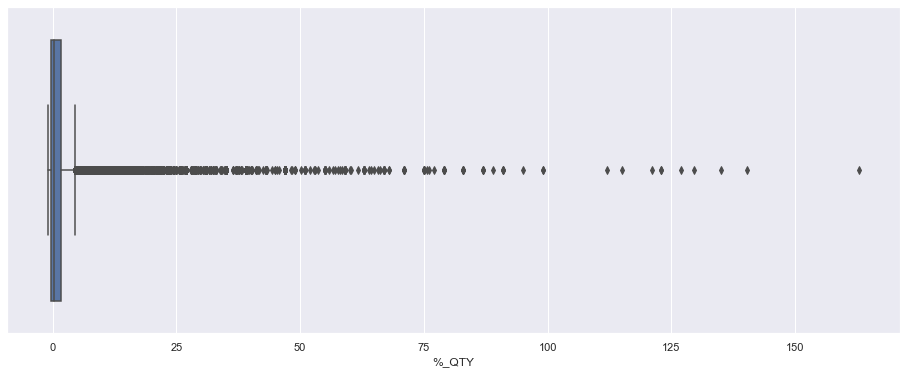

In [61]:
sns.boxplot(df_test['%_QTY']);

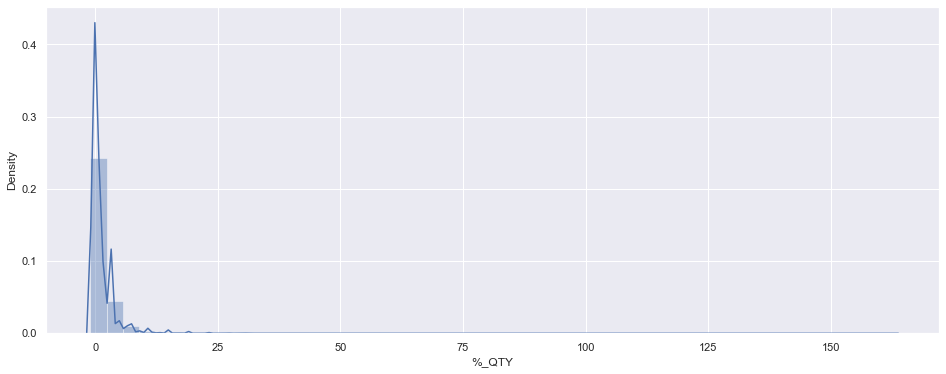

In [62]:
sns.distplot(df_test['%_QTY']);

In [63]:
q1 = df_training['%_QTY'].quantile(0.25)
q3 = df_training['%_QTY'].quantile(0.75)
iqr = q3-q1
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr
df_training_1 = df_training.loc[(df_training['%_QTY'] > fence_low) & (df_training['%_QTY'] < fence_high)]

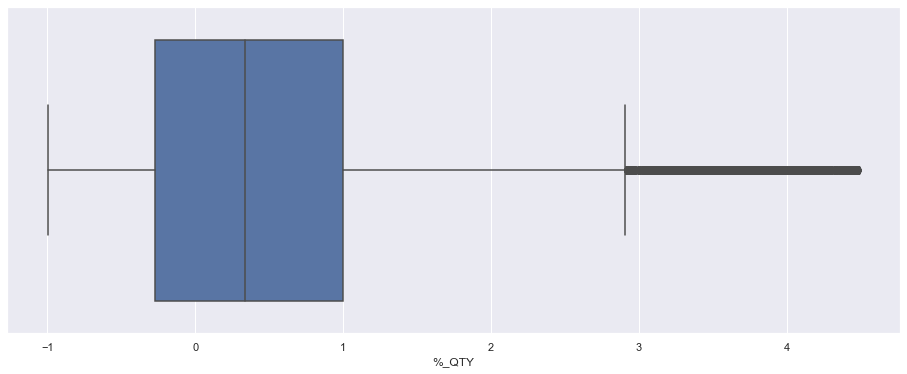

In [64]:
sns.boxplot(df_training_1['%_QTY']);

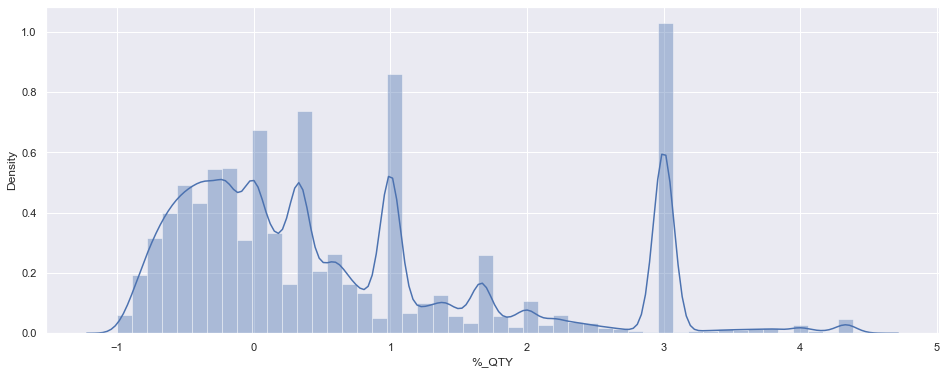

In [65]:
sns.distplot(df_training_1['%_QTY']);

In [66]:
len(df_test) / (len(df_training_1) + len(df_test)) * 100

22.922347907518322

# 5. Predictive Models

## Line base

In [67]:
y_test = df_test['SLS_QTY']
y_base_line =df_test['MEAN_QTY'].round(0).astype(int)

In [68]:
print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.567947739896298
191.19462074129538
13.82731429964964


In [69]:
REAL = df_test[['SKU_KEY','DAY_DATE', 'SLS_QTY']]
BASE_LINE = df_test[['SKU_KEY','DAY_DATE', 'MEAN_QTY']]

In [70]:
XXXXX= REAL.groupby('SKU_KEY')['SLS_QTY'].sum().reset_index()
XXXXX

,SKU_KEY,SLS_QTY
0,2,930
1,4,14855
2,6,1269
3,7,10633
4,9,83
...,...,...
10023,30855,9
10024,30863,8
10025,30864,10
10026,30865,5


In [71]:
REAL = REAL.loc[(REAL['SKU_KEY'] == 4)]
BASE_LINE = BASE_LINE.loc[(BASE_LINE['SKU_KEY'] == 4)]

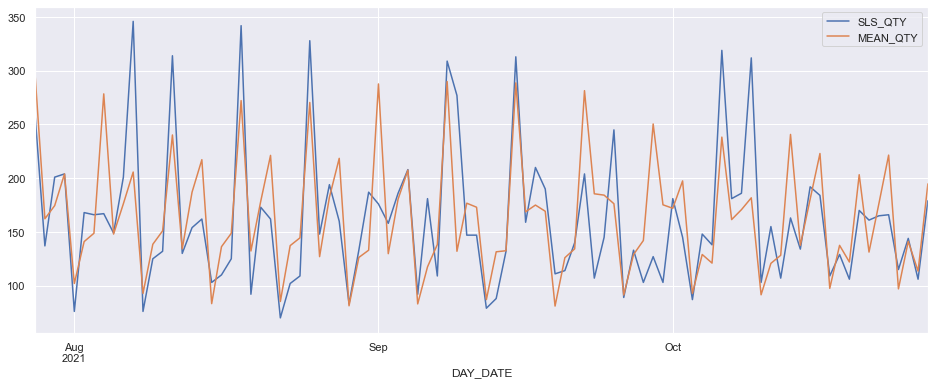

In [72]:
fig, ax = plt.subplots()
REAL.plot(x = 'DAY_DATE', y = 'SLS_QTY', ax = ax); 
BASE_LINE.plot(x = 'DAY_DATE', y = 'MEAN_QTY', ax = ax); 

## First attempt

### Original Sample

In [ ]:
del x_training
del y_training
del x_test
del y_test

In [73]:
x_training = df_training[['SKU_KEY', 'MEAN_QTY','PRICE_UNI']]
y_training = df_training['SLS_QTY']

In [74]:
x_test = df_test[['SKU_KEY', 'MEAN_QTY','PRICE_UNI']]
y_test = df_test['SLS_QTY']

In [75]:
regr = linear_model.LinearRegression()
regr.fit(x_training, y_training)
y_prediction = regr.predict(x_test).round(0).astype(int)

In [76]:
print(r2_score(y_test,y_prediction))
print(mean_squared_error(y_test,y_prediction))
print(np.sqrt(mean_squared_error(y_test,y_prediction)))

0.576949207670737
187.21123174840884
13.682515548992036


In [77]:
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(x_training, y_training)
y_prediction_regressor = regressor.predict(x_test).round(0).astype(int)

In [78]:
print(r2_score(y_test,y_prediction_regressor))
print(mean_squared_error(y_test,y_prediction_regressor))
print(np.sqrt(mean_squared_error(y_test,y_prediction_regressor)))

0.3128768193368079
304.070289779109
17.43761135531782


In [79]:
forest_regr = RandomForestRegressor(n_estimators=2, random_state=0)
forest_regr.fit(x_training, y_training)
y_prediction_forest_regr = forest_regr.predict(x_test).round(0).astype(int)

In [80]:
print(r2_score(y_test,y_prediction_forest_regr))
print(mean_squared_error(y_test,y_prediction_forest_regr))
print(np.sqrt(mean_squared_error(y_test,y_prediction_forest_regr)))

0.3823021270404049
273.34774391613627
16.533231502526547


In [81]:
boosting_regr = GradientBoostingRegressor(random_state=0)
boosting_regr.fit(x_training, y_training)
y_prediction_boosting_regr = boosting_regr.predict(x_test).round(0).astype(int)

In [82]:
print(r2_score(y_test,y_prediction_boosting_regr))
print(mean_squared_error(y_test,y_prediction_boosting_regr))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr)))

0.5965280907805617
178.5470550355672
13.36215009029487


### Sample without outliers

In [83]:
del regr
del y_prediction
del regressor
del y_prediction_regressor
del forest_regr
del y_prediction_forest_regr
del boosting_regr
del y_prediction_boosting_regr

In [84]:
x_training_out = df_training_1[['SKU_KEY', 'MEAN_QTY','PRICE_UNI']]
y_training_out = df_training_1['SLS_QTY']

In [85]:
regr = linear_model.LinearRegression()
regr.fit(x_training_out, y_training_out)
y_prediction = regr.predict(x_test).round(0).astype(int)

In [86]:
print(r2_score(y_test,y_prediction))
print(mean_squared_error(y_test,y_prediction))
print(np.sqrt(mean_squared_error(y_test,y_prediction)))

0.5760267689687137
187.61943541744665
13.697424408166912


In [87]:
regressor = DecisionTreeRegressor(random_state = 0) 
regressor.fit(x_training_out, y_training_out)
y_prediction_regressor = regressor.predict(x_test).round(0).astype(int)

In [88]:
print(r2_score(y_test,y_prediction_regressor))
print(mean_squared_error(y_test,y_prediction_regressor))
print(np.sqrt(mean_squared_error(y_test,y_prediction_regressor)))

0.41531766126247405
258.7374915761887
16.08531913193483


In [89]:
forest_regr = RandomForestRegressor(n_estimators=2, random_state=0)
forest_regr.fit(x_training_out, y_training_out)
y_prediction_forest_regr = forest_regr.predict(x_test).round(0).astype(int)

In [90]:
print(r2_score(y_test,y_prediction_forest_regr))
print(mean_squared_error(y_test,y_prediction_forest_regr))
print(np.sqrt(mean_squared_error(y_test,y_prediction_forest_regr)))

0.4984488544928888
221.94972669412206
14.897977268546294


In [91]:
boosting_regr = GradientBoostingRegressor(random_state=0)
boosting_regr.fit(x_training_out, y_training_out)
y_prediction_boosting_regr = boosting_regr.predict(x_test).round(0).astype(int)

In [92]:
print(r2_score(y_test,y_prediction_boosting_regr))
print(mean_squared_error(y_test,y_prediction_boosting_regr))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr)))

0.5826653171034686
184.6817012354923
13.58976457616144


## Second attempt

In [93]:
del x_training
del y_training
del x_test

In [94]:
del regr
del y_prediction
del regressor
del y_prediction_regressor
del forest_regr
del y_prediction_forest_regr
del boosting_regr
del y_prediction_boosting_regr

In [95]:
df_training_1.loc[df_training_1['TRAN_TYPE'] == 'R', 'PROMOCIONAL'] = 1
df_test.loc[df_test['TRAN_TYPE'] == 'R', 'PROMOCIONAL'] = 1

df_training_1.loc[df_training_1['MERCH_L2_DESC'] == 'PERECIVEIS', 'PERECIVEIS'] = 1
df_test.loc[df_test['MERCH_L2_DESC'] == 'PERECIVEIS', 'PERECIVEIS'] = 1

df_training_1 = df_training_1.fillna(0)
df_test = df_test.fillna(0)

In [96]:
x_training = df_training_1[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS']]
y_training = df_training_1['SLS_QTY']

In [97]:
x_test = df_test[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS']]

In [98]:
regr = linear_model.LinearRegression()
regr.fit(x_training, y_training)
y_prediction = regr.predict(x_test).round(0).astype(int)

In [99]:
print(r2_score(y_test,y_prediction))
print(mean_squared_error(y_test,y_prediction))
print(np.sqrt(mean_squared_error(y_test,y_prediction)))

0.5989035926062407
177.4958322725571
13.322756181532299


In [100]:
boosting_regr = GradientBoostingRegressor(random_state=0)
boosting_regr.fit(x_training, y_training)
y_prediction_boosting_regr = boosting_regr.predict(x_test).round(0).astype(int)

In [101]:
print(r2_score(y_test,y_prediction_boosting_regr))
print(mean_squared_error(y_test,y_prediction_boosting_regr))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr)))

0.6494802780703313
155.11430325720704
12.4544892812675


## Third attempt

In [102]:
del x_training
del y_training
del x_test

In [103]:
del regr
del y_prediction
del boosting_regr
del y_prediction_boosting_regr

In [104]:
df_training_1.loc[df_training_1['YEAR'] == '2021', 'YEAR_B'] = 1

df_test.loc[df_test['YEAR'] == '2021', 'YEAR_B'] = 1

df_training_1 = df_training_1.fillna(0)
df_test = df_test.fillna(0)

In [105]:
df_training_1['week_sin'] = np.sin((df_training_1.WEEK_NUMBER-1)*(2.*np.pi/53))
df_training_1['week_cos'] = np.sin((df_training_1.WEEK_NUMBER-1)*(2.*np.pi/53))
df_training_1['day_sin'] = np.sin((df_training_1.DAY_OF_WEEK-1)*(2.*np.pi/7))
df_training_1['day_cos'] = np.cos((df_training_1.DAY_OF_WEEK-1)*(2.*np.pi/7))

In [106]:
df_test['week_sin'] = np.sin((df_test.WEEK_NUMBER-1)*(2.*np.pi/53))
df_test['week_cos'] = np.sin((df_test.WEEK_NUMBER-1)*(2.*np.pi/53))
df_test['day_sin'] = np.sin((df_test.DAY_OF_WEEK-1)*(2.*np.pi/7))
df_test['day_cos'] = np.cos((df_test.DAY_OF_WEEK-1)*(2.*np.pi/7))

In [107]:
x_training = df_training_1[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos']]
y_training = df_training_1['SLS_QTY']

In [108]:
x_test = df_test[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos']]

In [109]:
regr = linear_model.LinearRegression()
regr.fit(x_training, y_training)
y_prediction = regr.predict(x_test).round(0).astype(int)

In [110]:
print(r2_score(y_test,y_prediction))
print(mean_squared_error(y_test,y_prediction))
print(np.sqrt(mean_squared_error(y_test,y_prediction)))

0.5991142003962374
177.40263272182702
13.319257964384766


In [111]:
boosting_regr = GradientBoostingRegressor(random_state=0)
boosting_regr.fit(x_training, y_training)
y_prediction_boosting_regr = boosting_regr.predict(x_test).round(0).astype(int)

In [112]:
print(r2_score(y_test,y_prediction_boosting_regr))
print(mean_squared_error(y_test,y_prediction_boosting_regr))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr)))

0.6534615483883686
153.35248521153127
12.383557050037412


## Fourth attempt

In [113]:
del x_training
del y_training
del x_test

In [114]:
del regr
del y_prediction
del boosting_regr
del y_prediction_boosting_regr

In [115]:
x_training = df_training_1[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training = df_training_1['SLS_QTY']

In [116]:
x_test = df_test[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

In [117]:
regr = linear_model.LinearRegression()
regr.fit(x_training, y_training)
y_prediction = regr.predict(x_test).round(0).astype(int)

In [118]:
print(r2_score(y_test,y_prediction))
print(mean_squared_error(y_test,y_prediction))
print(np.sqrt(mean_squared_error(y_test,y_prediction)))

0.6188697891068988
168.66025907899663
12.98692646775967


In [119]:
boosting_regr = GradientBoostingRegressor(random_state=0)
boosting_regr.fit(x_training, y_training)
y_prediction_boosting_regr = boosting_regr.predict(x_test).round(0).astype(int)

In [120]:
print(r2_score(y_test,y_prediction_boosting_regr))
print(mean_squared_error(y_test,y_prediction_boosting_regr))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr)))

0.6738372107783865
144.33571246724074
12.013979876262518


In [ ]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(5,), max_iter=200)
mlp_reg.fit(x_training, y_training)
y_prediction_mlp_reg = mlp_reg.predict(x_test).round(0).astype(int)

In [ ]:
print(r2_score(y_test,y_prediction_mlp_reg))
print(mean_squared_error(y_test,y_prediction_mlp_reg))
print(np.sqrt(mean_squared_error(y_test,y_prediction_mlp_reg)))

In [121]:
training_global = x_training
training_global['SLS_QTY'] = df_training_1['SLS_QTY']

test_global = x_test
test_global['SLS_QTY'] = df_test['SLS_QTY']

In [122]:
hostname='159.8.121.234'
dbname='P3G11'
uname='a20201834'
pwd='2Ec1Hk'

engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=uname, pw=pwd))
training_global.to_sql('training_global', engine, if_exists='replace', index=False)
test_global.to_sql('test_global', engine, if_exists='replace', index=False)

## Fifth attempt

In [123]:
del x_training
del y_training
del x_test
del y_test
del y_base_line

In [124]:
del regr
del y_prediction
del boosting_regr
del y_prediction_boosting_regr

In [130]:
df_training_v2 = df_training_1.loc[df_training['MERCH_L4_DESC'] == 'QUEIJOS']
df_test_v2 = df_test.loc[df_test['MERCH_L4_DESC'] == 'QUEIJOS']

In [131]:
y_test = df_test_v2['SLS_QTY']
y_base_line =df_test_v2['MEAN_QTY'].round(0).astype(int)

In [132]:
print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.4149789798405391
263.8003670473083
16.241932368019157


In [133]:
x_training = df_training_v2[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training = df_training_v2['SLS_QTY']

In [134]:
x_test = df_test_v2[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

In [135]:
regr = linear_model.LinearRegression()
regr.fit(x_training, y_training)
y_prediction = regr.predict(x_test).round(0).astype(int)

In [136]:
print(r2_score(y_test,y_prediction))
print(mean_squared_error(y_test,y_prediction))
print(np.sqrt(mean_squared_error(y_test,y_prediction)))

0.557482540571471
199.54200652528547
14.125933828433626


In [137]:
boosting_regr = GradientBoostingRegressor(random_state=0)
boosting_regr.fit(x_training, y_training)
y_prediction_boosting_regr = boosting_regr.predict(x_test).round(0).astype(int)

In [138]:
print(r2_score(y_test,y_prediction_boosting_regr))
print(mean_squared_error(y_test,y_prediction_boosting_regr))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr)))

0.7400108064276185
117.2355220228385
10.827535362345325


# 6. Cannibalism

In [139]:
canibalismo = new_sample_df

## Select Sample

In [140]:
canibalismo = canibalismo.loc[(canibalismo['MERCH_L4_DESC'] == 'QUEIJOS') & ((canibalismo['MERCH_L5_DESC'] == 'MUSSARELA'))]

In [141]:
canibalismo.loc[canibalismo['TRAN_TYPE'] == 'P', 'PROMOCIONAL'] = 1
canibalismo = canibalismo.fillna(0)
canibalismo['PROMOCIONAL'] = pd.to_numeric(canibalismo['PROMOCIONAL'], downcast='integer')
canibalismo_v1 = canibalismo[['DAY_DATE', 'SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
canibalismo

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,%_QTY,PROMOCIONAL
4,581,168,42,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0.00,0
265,24093,59,1,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.00,0.00,0
1197,639,628,28,P,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.43,0.00,1
1762,6290,13,3,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.33,0.00,0
2572,674,40,1,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679196,12449,13,1,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,0.75,2.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,4.0,8.0,5.0,4.0,13.00,0.33,0
2680467,14596,198,33,P,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,13.75,24.0,7.0,15.0,28.0,22.0,9.0,16.0,9.0,7.0,10.0,4.0,7.0,6.00,1.40,1
2680512,639,188,5,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,7.50,9.0,8.0,7.0,8.0,8.0,9.0,11.0,16.0,12.0,15.0,9.0,9.0,37.60,-0.33,0
2681601,15724,119,19,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,27.75,75.0,26.0,75.0,68.0,95.0,138.0,91.0,71.0,90.0,61.0,52.0,31.0,6.26,-0.32,0


In [143]:
SKU_437 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 437]
SKU_581 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 581]
SKU_639 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 639]
SKU_674 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 674]
SKU_1883 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 1883]
SKU_6290 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 6290]
SKU_6352 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 6352]
SKU_12004 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 12004]
SKU_12449 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 12449]
SKU_14596 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 14596]
SKU_14633 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 14633]
SKU_15724 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 15724]
SKU_15725 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 15725]
SKU_24093 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 24093]
SKU_24225 = canibalismo_v1.loc[canibalismo_v1['SKU_KEY'] == 24225]

## Graphs

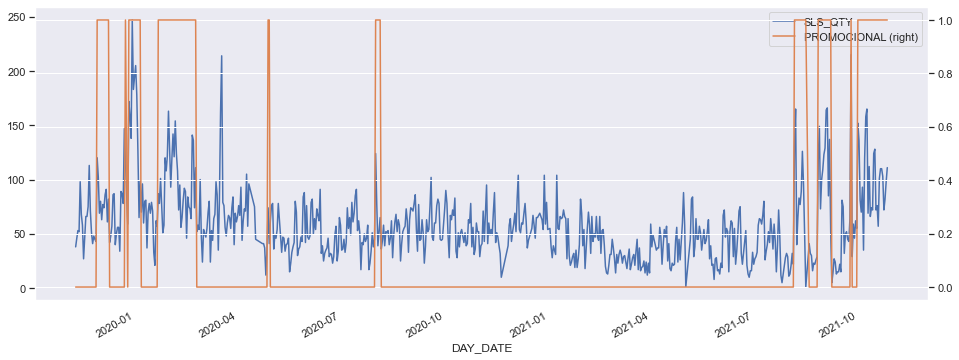

In [144]:
fig, ax = plt.subplots()
SKU_12004.plot(x = 'DAY_DATE', y = 'SLS_QTY', ax = ax); 
SKU_12004.plot(x = 'DAY_DATE', y = 'PROMOCIONAL', ax = ax, secondary_y = True); 

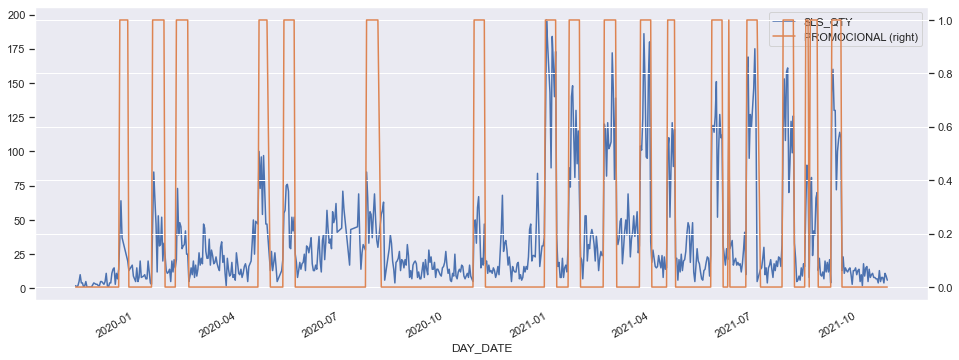

In [145]:
fig, ax = plt.subplots()
SKU_15725.plot(x = 'DAY_DATE', y = 'SLS_QTY', ax = ax); 
SKU_15725.plot(x = 'DAY_DATE', y = 'PROMOCIONAL', ax = ax, secondary_y = True); 

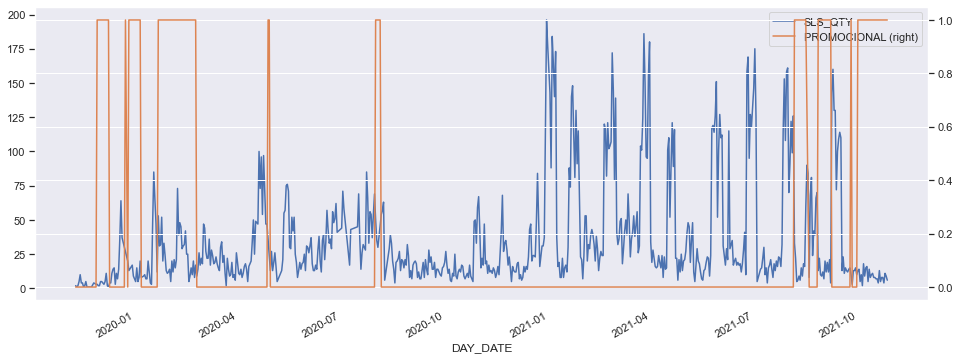

In [146]:
fig, ax = plt.subplots()
SKU_15725.plot(x = 'DAY_DATE', y = 'SLS_QTY', ax = ax); 
SKU_12004.plot(x = 'DAY_DATE', y = 'PROMOCIONAL', ax = ax, secondary_y = True); 

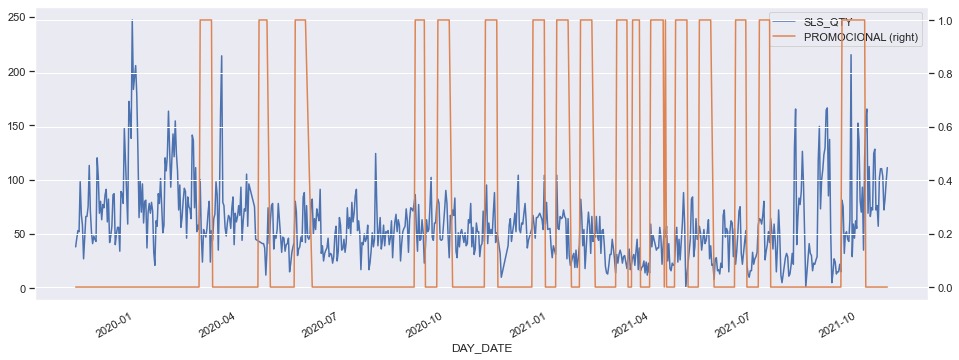

In [147]:
fig, ax = plt.subplots()
SKU_12004.plot(x = 'DAY_DATE', y = 'SLS_QTY', ax = ax); 
SKU_15724.plot(x = 'DAY_DATE', y = 'PROMOCIONAL', ax = ax, secondary_y = True); 

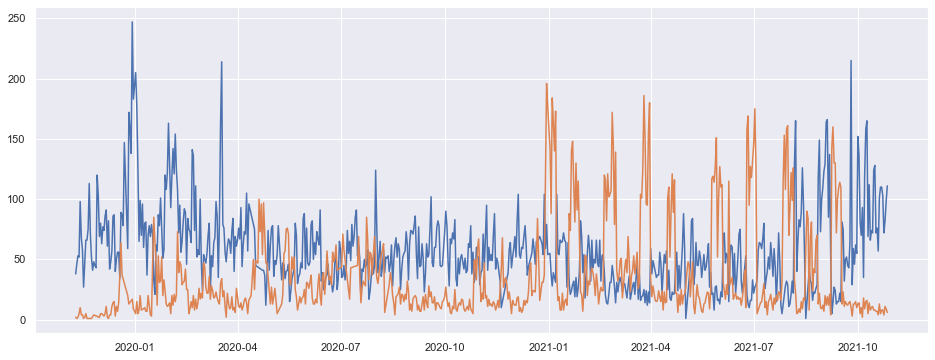

In [148]:
plt.plot(SKU_12004['DAY_DATE'], SKU_12004['SLS_QTY']);
plt.plot(SKU_15725['DAY_DATE'], SKU_15725['SLS_QTY']);

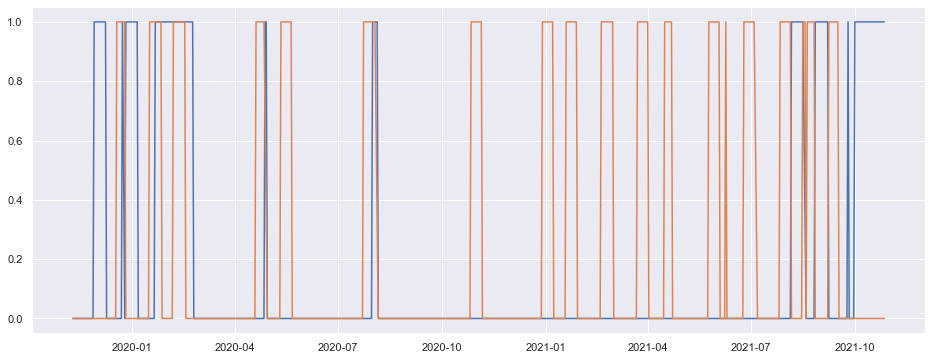

In [149]:
plt.plot(SKU_12004['DAY_DATE'], SKU_12004['PROMOCIONAL']);
plt.plot(SKU_15725['DAY_DATE'], SKU_15725['PROMOCIONAL']);

## Correlation

In [150]:
split_date_3 ='2019-11-10'
split_date_4 ='2021-10-27'
calendar_v1 = calendar['DAY_DATE'].reset_index()
calendar_v1 = calendar_v1.drop('index', 1)
calendar_df = calendar_v1.loc[(calendar_v1['DAY_DATE'] >= split_date_3) & (calendar_v1['DAY_DATE'] <= split_date_4)]
calendar_df1 = calendar_df.reset_index()
calendar_df2 = calendar_df1.drop('index', 1)
calendar_df2

,DAY_DATE
0,2019-11-10
1,2019-11-11
2,2019-11-12
3,2019-11-13
4,2019-11-14
...,...
713,2021-10-23
714,2021-10-24
715,2021-10-25
716,2021-10-26


In [151]:
SKUs = canibalismo['SKU_KEY'].unique()
SKUS_v2 = np.sort(SKUs)

In [152]:
ohc = OneHotEncoder()
ohe = ohc.fit_transform(canibalismo.SKU_KEY.values.reshape(-1,1)).toarray()
dfOneHot1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
dfOneHot2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

In [153]:
for i in range(len(SKUS_v2)):
    dfOneHot1.iloc[:, i] = SKUS_v2[i]
for i in range(len(SKUS_v2)):
    dfOneHot2.iloc[:, i] = SKUS_v2[i]

In [154]:
join_skus = pd.concat([calendar_df2, dfOneHot1, dfOneHot2], axis =1)

In [155]:
col_v1 = join_skus.columns.values

In [156]:
for i in range(len(col_v1)-1):
    join_skus.iloc[:, i+1] = join_skus.iloc[:, 0].astype(str) + space + join_skus.iloc[:, i+1].astype(str)

In [157]:
join_skus_v2 = join_skus

In [158]:
canibalismo["CONCAT_SKU_KEY"] = canibalismo["DAY_DATE"].astype(str) + space + canibalismo["SKU_KEY"].astype(str)
canibalismo_v1 = canibalismo[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]

In [159]:
ohe = ohc.fit_transform(canibalismo.SKU_KEY.values.reshape(-1,1)).toarray()
dfOneHot3 = pd.DataFrame(canibalismo_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
dfOneHot4 = pd.DataFrame(canibalismo_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
dfOneHot5 = pd.DataFrame(canibalismo_v1, columns = ['QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
dfOneHot6 = pd.DataFrame(canibalismo_v1, columns = ['PQTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

In [160]:
for i in range(len(SKUS_v2)):
    dfOneHot3.iloc[:, i] = canibalismo_v1['CONCAT_SKU_KEY']
for i in range(len(SKUS_v2)):
    dfOneHot4.iloc[:, i] = canibalismo_v1['CONCAT_SKU_KEY']
for i in range(len(SKUS_v2)):
    dfOneHot5.iloc[:, i] = canibalismo_v1['SLS_QTY']
for i in range(len(SKUS_v2)):
    dfOneHot6.iloc[:, i] = canibalismo_v1['PROMOCIONAL']

In [161]:
join_canibalismo = pd.concat([dfOneHot3, dfOneHot4, dfOneHot5, dfOneHot6], axis =1)
join_canibalismo

,SLS_QTY_437,SLS_QTY_581,SLS_QTY_639,SLS_QTY_674,SLS_QTY_1883,SLS_QTY_6290,SLS_QTY_6352,SLS_QTY_12004,SLS_QTY_12449,SLS_QTY_14596,SLS_QTY_14633,SLS_QTY_15724,SLS_QTY_15725,SLS_QTY_24093,SLS_QTY_24225,PROMO_437,PROMO_581,PROMO_639,PROMO_674,PROMO_1883,PROMO_6290,PROMO_6352,PROMO_12004,PROMO_12449,PROMO_14596,PROMO_14633,PROMO_15724,PROMO_15725,PROMO_24093,PROMO_24225,QTY_437,QTY_581,QTY_639,QTY_674,QTY_1883,QTY_6290,QTY_6352,QTY_12004,QTY_12449,QTY_14596,QTY_14633,QTY_15724,QTY_15725,QTY_24093,QTY_24225,PQTY_437,PQTY_581,PQTY_639,PQTY_674,PQTY_1883,PQTY_6290,PQTY_6352,PQTY_12004,PQTY_12449,PQTY_14596,PQTY_14633,PQTY_15724,PQTY_15725,PQTY_24093,PQTY_24225
4,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,2019-11-10+581,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
265,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,2019-11-10+24093,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1197,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,2019-11-10+639,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1762,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,2019-11-10+6290,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2572,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,2019-11-10+674,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679196,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021-10-27+12449,2021

In [162]:
col_v2 = join_canibalismo.columns.values

In [163]:
for i in range(len(col_v2)-30):
    join_skus_v2 = join_skus_v2.merge(join_canibalismo[[col_v2[i], col_v2[i+30]]], on =col_v2[i], how = 'left')
    
join_skus_v2.drop(join_skus_v2.iloc[:, 1:31], inplace = True, axis = 1)
join_skus_v2 = join_skus_v2.fillna(0)
join_skus_v2

,DAY_DATE,QTY_437,QTY_581,QTY_639,QTY_674,QTY_1883,QTY_6290,QTY_6352,QTY_12004,QTY_12449,QTY_14596,QTY_14633,QTY_15724,QTY_15725,QTY_24093,QTY_24225,PQTY_437,PQTY_581,PQTY_639,PQTY_674,PQTY_1883,PQTY_6290,PQTY_6352,PQTY_12004,PQTY_12449,PQTY_14596,PQTY_14633,PQTY_15724,PQTY_15725,PQTY_24093,PQTY_24225
0,2019-11-10,0.0,42.0,28.0,1.0,0.0,3.0,0.0,38.0,1.0,2.0,7.0,4.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2019-11-11,0.0,57.0,34.0,3.0,0.0,4.0,2.0,46.0,4.0,7.0,1.0,8.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2019-11-12,0.0,72.0,33.0,1.0,0.0,8.0,0.0,53.0,3.0,6.0,11.0,6.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2019-11-13,0.0,70.0,34.0,2.0,0.0,5.0,0.0,52.0,2.0,3.0,0.0,10.0,5.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-14,0.0,80.0,51.0,5.0,6.0,14.0,3.0,98.0,4.0,2.0,0.0,11.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
713,2021-10-23,0.0,93.0,3.0,0.0,2.0,0.0,0.0,103.0,1.0,28.0,2.0,11.0,8.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
714,2021-10-24,0.0,62.0,6.0,0.0,1.0,0.0,0.0,72.0,1.0,23.0,7.0,12.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
715,2021-10-25,0.0,102.0,8.0,0.0,1.0,0.0,0.0,82.0,0.0,42.0,3.0,11.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
716,2021-10-26,0.0,101.0,4.0,0.0,2.0,0.0,0.0,98.0,2.0,33.0,0.0,13.0,9.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [164]:
df_corrM = join_skus_v2.corr().reset_index()
df_corrM

,index,QTY_437,QTY_581,QTY_639,QTY_674,QTY_1883,QTY_6290,QTY_6352,QTY_12004,QTY_12449,QTY_14596,QTY_14633,QTY_15724,QTY_15725,QTY_24093,QTY_24225,PQTY_437,PQTY_581,PQTY_639,PQTY_674,PQTY_1883,PQTY_6290,PQTY_6352,PQTY_12004,PQTY_12449,PQTY_14596,PQTY_14633,PQTY_15724,PQTY_15725,PQTY_24093,PQTY_24225
0,QTY_437,1.000000,0.043531,0.203214,-0.061292,0.068493,0.120481,0.099670,0.107299,-0.002108,-0.063699,0.071549,-0.065537,-0.034394,0.006761,0.014772,NaN,-0.005403,0.059918,NaN,0.010951,-0.016213,NaN,0.146908,0.014535,-0.022596,0.064240,-0.063649,0.075195,-0.012897,-0.009729
1,QTY_581,0.043531,1.000000,0.231059,0.057304,0.140865,0.209827,0.112465,0.228543,-0.001850,-0.096171,0.128455,-0.368642,-0.023905,0.126634,0.108089,NaN,0.631018,0.005227,NaN,0.067720,-0.007626,NaN,0.026809,-0.062969,-0.056406,-0.053752,-0.313306,-0.064591,-0.004519,0.006698
2,QTY_639,0.203214,0.231059,1.000000,0.099396,0.349337,0.495442,0.160325,0.488498,0.118221,-0.229188,0.292979,-0.214816,-0.136021,0.170421,0.266676,NaN,-0.114419,0.440058,NaN,-0.014068,0.005440,NaN,0.224738,0.068418,-0.137333,0.329628,-0.231158,-0.032692,0.074129,-0.010419
3,QTY_674,-0.061292,0.057304,0.099396,1.000000,-0.035999,0.126526,0.283433,0.021775,-0.017803,0.006894,0.017984,0.104707,0.040877,0.102812,0.091951,NaN,-0.043362,0.008914,NaN,-0.119845,-0.003865,NaN,-0.151341,-0.088129,0.007392,-0.042992,0.022582,-0.068902,0.005549,0.039965
4,QTY_1883,0.068493,0.140865,0.349337,-0.035999,1.000000,0.225288,0.027281,0.260525,0.180360,-0.021336,0.112411,0.011065,-0.039770,0.024014,0.156859,NaN,-0.040541,-0.051946,NaN,0.422647,-0.016717,NaN,0.157410,0.134583,-0.010202,0.261918,-0.053749,-0.047207,-0.028089,0.000156
5,QTY_6290,0.120481,0.209827,0.495442,0.126526,0.225288,1.000000,0.084076,0.317876,0.041833,-0.255197,0.200021,-0.207661,-0.147751,0.098938,0.211247,NaN,-0.034214,0.175564,NaN,-0.023915,0.140984,NaN,0.142557,0.100080,-0.058084,0.261527,-0.168497,-0.064894,-0.039734,-0.058725
6,QTY_6352,0.099670,0.112465,0.160325,0.283433,0.027281,0.084076,1.000000,0.149735,0.135623,0.002702,0.125720,0.068342,-0.024720,0.066110,0.117896,NaN,-0.042755,-0.002218,NaN,-0.035739,0.009908,NaN,-0.049608,0.013849,-0.020185,0.038609,0.007398,-0.037176,0.000346,0.015892
7,QTY_12004,0.107299,0.228543,0.488498,0.021775,0.260525,0.317876,0.149735,1.000000,0.088128,-0.079321,0.275301,-0.032571,-0.374366,0.091030,0.167420,NaN,0.032392,0.025017,NaN,-0.013838,-0.051357,NaN,0.586989,-0.002026,-0.027674,0.187003,-0.062253,-0.304408,0.026406,-0.044852
8,QTY_12449,-0.002108,-0.001850,0.118221,-0.017803,0.180360,0.041833,0.135623,0.088128,1.000000,-0.062606,0.159440,-0.029943,-0.014368,0.066977,0.146397,NaN,-0.063040,-0.051311,NaN,0.133217,-0.032886,NaN,0.081347,0.511187,-0.062173,0.246456,-0.056787,0.035454,-0.006095,-0.001214
9,QTY_14596,-0.063699,-0.096171,-0.229188,0.006894,-0.021336,-0.255197,0.002702,-0.079321,-0.062606,1.000000,-0.064338,0.044045,0.157249,-0.088962,-0.083164,NaN,-0.095121,-0.144845,NaN,-0.039228,-0.028779,NaN,-0.066080,-0.090086,0.651166,-0.106874,-0.063741,0.005894,-0.025147,0.033445


In [165]:
df_corrM_v2 = df_corrM
df_corrM_v2 = df_corrM_v2.fillna(0)

In [166]:
df_corrM_v2.drop(df_corrM_v2.iloc[:, 16:31], inplace = True, axis = 1)
df_corrM_v3 = df_corrM_v2.drop(df_corrM_v2.index[0:15])
df_corrM_v3['A'], df_corrM_v3['SKU_KEY'] = df_corrM_v3['index'].str.split('_', 1).str
df_corrM_v3 

,index,QTY_437,QTY_581,QTY_639,QTY_674,QTY_1883,QTY_6290,QTY_6352,QTY_12004,QTY_12449,QTY_14596,QTY_14633,QTY_15724,QTY_15725,QTY_24093,QTY_24225,A,SKU_KEY
15,PQTY_437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,437
16,PQTY_581,-0.005403,0.631018,-0.114419,-0.043362,-0.040541,-0.034214,-0.042755,0.032392,-0.063040,-0.095121,0.025341,-0.211773,-0.130009,-0.009064,-0.049192,PQTY,581
17,PQTY_639,0.059918,0.005227,0.440058,0.008914,-0.051946,0.175564,-0.002218,0.025017,-0.051311,-0.144845,0.062628,-0.190875,-0.081288,0.115937,0.018116,PQTY,639
18,PQTY_674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,674
19,PQTY_1883,0.010951,0.067720,-0.014068,-0.119845,0.422647,-0.023915,-0.035739,-0.013838,0.133217,-0.039228,0.015391,0.052730,-0.090867,-0.048300,-0.028554,PQTY,1883
20,PQTY_6290,-0.016213,-0.007626,0.005440,-0.003865,-0.016717,0.140984,0.009908,-0.051357,-0.032886,-0.028779,0.177037,0.006634,0.106838,0.078885,-0.037230,PQTY,6290
21,PQTY_6352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,6352
22,PQTY_12004,0.146908,0.026809,0.224738,-0.151341,0.157410,0.142557,-0.049608,0.586989,0.081347,-0.066080,0.169465,-0.181296,-0.208241,-0.036454,0.051594,PQTY,12004
23,PQTY_12449,0.014535,-0.062969,0.068418,-0.088129,0.134583,0.100080,0.013849,-0.002026,0.511187,-0.090086,0.103566,-0.107601,-0.049414,0.018954,0.077021,PQTY,12449
24,PQTY_14596,-0.022596,-0.056406,-0.137333,0.007392,-0.010202,-0.058084,-0.020185,-0.027674,-0.062173,0.651166,-0.088549,-0.044135,-0.021398,-0.036415,0.015021,PQTY,14596


In [167]:
col_v3 = df_corrM_v3.columns.values

In [168]:
for i in range(len(col_v3)-2):
    df_corrM_v3.loc[df_corrM_v3[col_v3[i+1]] > df_corrM_v3[col_v3[i+1]].min(), col_v3[i+1]] = 0
df_corrM_v3

,index,QTY_437,QTY_581,QTY_639,QTY_674,QTY_1883,QTY_6290,QTY_6352,QTY_12004,QTY_12449,QTY_14596,QTY_14633,QTY_15724,QTY_15725,QTY_24093,QTY_24225,A,SKU_KEY
15,PQTY_437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,437
16,PQTY_581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.06304,0.000000,0.000000,-0.211773,0.000000,0.000000,0.000000,PQTY,581
17,PQTY_639,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.144845,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,639
18,PQTY_674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,674
19,PQTY_1883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,1883
20,PQTY_6290,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,6290
21,PQTY_6352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,6352
22,PQTY_12004,0.000000,0.000000,0.000000,-0.151341,0.000000,0.000000,-0.049608,0.000000,0.00000,0.000000,0.000000,0.000000,-0.208241,0.000000,0.000000,PQTY,12004
23,PQTY_12449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PQTY,12449
24,PQTY_14596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-0.088549,0.000000,0.000000,0.000000,0.000000,PQTY,14596


In [169]:
df_corrM_v4 = df_corrM_v3
for i in range(len(col_v3)-3):
    df_corrM_v4.loc[df_corrM_v4[col_v3[i+1]].astype(float) > -0.2, col_v3[i+1]] = 0
df_corrM_v4      

,index,QTY_437,QTY_581,QTY_639,QTY_674,QTY_1883,QTY_6290,QTY_6352,QTY_12004,QTY_12449,QTY_14596,QTY_14633,QTY_15724,QTY_15725,QTY_24093,QTY_24225,A,SKU_KEY
15,PQTY_437,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,PQTY,437
16,PQTY_581,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-0.211773,0.000000,0.0,0.0,PQTY,581
17,PQTY_639,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,PQTY,639
18,PQTY_674,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,PQTY,674
19,PQTY_1883,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,PQTY,1883
20,PQTY_6290,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,PQTY,6290
21,PQTY_6352,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,PQTY,6352
22,PQTY_12004,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.208241,0.0,0.0,PQTY,12004
23,PQTY_12449,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,PQTY,12449
24,PQTY_14596,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,PQTY,14596


In [170]:
df_corrM_v5 = df_corrM_v4
for i in range(len(col_v3)-3):
    df_corrM_v5.loc[df_corrM_v5[col_v3[i+1]] != 0, col_v3[i+1]] = df_corrM_v5['SKU_KEY']     

    df_corrM_v5['SKUs_Canibal'] = 0
df_corrM_v5

,index,QTY_437,QTY_581,QTY_639,QTY_674,QTY_1883,QTY_6290,QTY_6352,QTY_12004,QTY_12449,QTY_14596,QTY_14633,QTY_15724,QTY_15725,QTY_24093,QTY_24225,A,SKU_KEY,SKUs_Canibal
15,PQTY_437,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,PQTY,437,0
16,PQTY_581,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,581,0,0.0,0.0,PQTY,581,0
17,PQTY_639,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,PQTY,639,0
18,PQTY_674,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,PQTY,674,0
19,PQTY_1883,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,PQTY,1883,0
20,PQTY_6290,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,PQTY,6290,0
21,PQTY_6352,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,PQTY,6352,0
22,PQTY_12004,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,12004,0.0,0.0,PQTY,12004,0
23,PQTY_12449,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,PQTY,12449,0
24,PQTY_14596,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0,0.0,0.0,PQTY,14596,0


In [171]:
df_corrM_v6 = df_corrM_v5
for i in range(len(col_v3)-4):
    df_corrM_v6[col_v3[i+1]] = pd.to_numeric(df_corrM_v6[col_v3[i+1]], downcast='integer')

In [172]:
df_corrM_v7 = df_corrM_v6
for i in range(len(col_v3)-4):
    df_corrM_v7.at[i+15, 'SKUs_Canibal'] = df_corrM_v7[col_v3[i+1]].max()
df_corrM_v7

,index,QTY_437,QTY_581,QTY_639,QTY_674,QTY_1883,QTY_6290,QTY_6352,QTY_12004,QTY_12449,QTY_14596,QTY_14633,QTY_15724,QTY_15725,QTY_24093,QTY_24225,A,SKU_KEY,SKUs_Canibal
15,PQTY_437,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,PQTY,437,0
16,PQTY_581,0,0,0,0,0,0,0,0,0,0,0,581,0,0,0.0,PQTY,581,15724
17,PQTY_639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,PQTY,639,15724
18,PQTY_674,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,PQTY,674,0
19,PQTY_1883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,PQTY,1883,0
20,PQTY_6290,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,PQTY,6290,0
21,PQTY_6352,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,PQTY,6352,0
22,PQTY_12004,0,0,0,0,0,0,0,0,0,0,0,0,12004,0,0.0,PQTY,12004,15725
23,PQTY_12449,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,PQTY,12449,0
24,PQTY_14596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,PQTY,14596,0


In [173]:
df_corrM_v7['SKU_KEY'] = pd.to_numeric(df_corrM_v7['SKU_KEY'], downcast='integer')
SKUs_df = df_corrM_v7[['SKU_KEY', 'SKUs_Canibal']]
SKUs_df

,SKU_KEY,SKUs_Canibal
15,437,0
16,581,15724
17,639,15724
18,674,0
19,1883,0
20,6290,0
21,6352,0
22,12004,15725
23,12449,0
24,14596,0


In [174]:
canibalismo_df = pd.merge(canibalismo,SKUs_df,how='left',on='SKU_KEY')
canibalismo_df["CONCAT_PROMO"] = canibalismo_df["SKUs_Canibal"].astype(str) + space + canibalismo_df["DAY_DATE"].astype(str)
canibalismo_df

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,%_QTY,PROMOCIONAL,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO
0,581,168,42,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0.00,0,2019-11-10+581,15724,15724+2019-11-10
1,24093,59,1,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.00,0.00,0,2019-11-10+24093,0,0+2019-11-10
2,639,628,28,P,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.43,0.00,1,2019-11-10+639,15724,15724+2019-11-10
3,6290,13,3,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.33,0.00,0,2019-11-10+6290,0,0+2019-11-10
4,674,40,1,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.00,0.00,0,2019-11-10+674,0,0+2019-11-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7052,12449,13,1,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,0.75,2.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,4.0,8.0,5.0,4.0,13.00,0.33,0,2021-10-27+12449,0,0+2021-10-27
7053,14596,198,33,P,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,13.75,24.0,7.0,15.0,28.0,22.0,9.0,16.0,9.0,7.0,10.0,4.0,7.0,6.00,1.40,1,2021-10-27+14596,0,0+2021-10-27
7054,639,188,5,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,7.50,9.0,8.0,7.0,8.0,8.0,9.0,11.0,16.0,12.0,15.0,9.0,9.0,37.60,-0.33,0,2021-10-27+639,15724,15724+2021-10-27
7055,15724,119,19,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,27.75,75.0,26.0,75.0,68.0,95.0,138.0,91.0,71.0,90.0,61.0,52.0,31.0,6.26,-0.32,0,2021-10-27+15724,581,581+2021-10-27


In [175]:
canibalismo_v2 = canibalismo
canibalismo_v2["CONCAT_PROMO"] = canibalismo["SKU_KEY"].astype(str) + space + canibalismo["DAY_DATE"].astype(str)
canibalismo_v2["PROMO_CANIBAL"] = canibalismo_v2["PROMOCIONAL"]
canibalismo_v3 = canibalismo_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]
canibalismo_v3

,CONCAT_PROMO,PROMO_CANIBAL
4,581+2019-11-10,0
265,24093+2019-11-10,0
1197,639+2019-11-10,1
1762,6290+2019-11-10,0
2572,674+2019-11-10,0
...,...,...
2679196,12449+2021-10-27,0
2680467,14596+2021-10-27,1
2680512,639+2021-10-27,0
2681601,15724+2021-10-27,0


In [176]:
canibalismo_df_v2 = pd.merge(canibalismo_df,canibalismo_v3,how='left',on='CONCAT_PROMO')
canibalismo_df_v2 = canibalismo_df_v2.fillna(0)
canibalismo_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,%_QTY,PROMOCIONAL,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,581,168,42,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0.00,0,2019-11-10+581,15724,15724+2019-11-10,0
1,24093,59,1,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59.00,0.00,0,2019-11-10+24093,0,0+2019-11-10,0
2,639,628,28,P,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.43,0.00,1,2019-11-10+639,15724,15724+2019-11-10,0
3,6290,13,3,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.33,0.00,0,2019-11-10+6290,0,0+2019-11-10,0
4,674,40,1,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.00,0.00,0,2019-11-10+674,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7052,12449,13,1,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,0.75,2.0,3.0,3.0,4.0,3.0,3.0,4.0,4.0,4.0,8.0,5.0,4.0,13.00,0.33,0,2021-10-27+12449,0,0+2021-10-27,0
7053,14596,198,33,P,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,13.75,24.0,7.0,15.0,28.0,22.0,9.0,16.0,9.0,7.0,10.0,4.0,7.0,6.00,1.40,1,2021-10-27+14596,0,0+2021-10-27,0
7054,639,188,5,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,7.50,9.0,8.0,7.0,8.0,8.0,9.0,11.0,16.0,12.0,15.0,9.0,9.0,37.60,-0.33,0,2021-10-27+639,15724,15724+2021-10-27,0
7055,15724,119,19,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,27.75,75.0,26.0,75.0,68.0,95.0,138.0,91.0,71.0,90.0,61.0,52.0,31.0,6.26,-0.32,0,2021-10-27+15724,581,581+2021-10-27,1


# Analysis by category L4

In [180]:
db_connection = pymysql.connect(host = '159.8.121.234',
                                user = 'a20201834',
                                password = '2Ec1Hk',
                                database = 'P3G11')

In [181]:
del new_sample_df

In [182]:
new_sample_df1 = pd.read_sql('SELECT * FROM new_sample_df1', con = db_connection)
new_sample_df2 = pd.read_sql('SELECT * FROM new_sample_df2', con = db_connection)

In [183]:
new_sample_df = pd.concat([new_sample_df2, new_sample_df1], axis =1)
new_sample_df 

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI
0,551,21,1,R,PERECIVEIS,FLC,QUEIJOS,MINAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.00
1,555,7,1,R,PERECIVEIS,FLV,LEGUMES,PEPINO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00
2,556,150,7,R,PERECIVEIS,CARNES,CARNE BOVINA TRASEIRO,FRALDINHA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.43
3,576,3,2,R,NAO PERECIVEIS,MERCEARIA,MASSAS,INSTANTANEO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.50
4,581,168,42,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681608,14921,10,3,R,NAO PERECIVEIS,HIGIENE,SABONETE,BARRA,2021-10-27,2021,10,27,43,2,5.25,5.0,6.0,4.0,0.0,0.0,5.0,6.0,6.0,6.0,7.0,8.0,8.0,3.33
2681609,15726,98,6,R,PERECIVEIS,FLC,QUEIJOS,PRATO,2021-10-27,2021,10,27,43,2,4.00,7.0,11.0,15.0,16.0,10.0,12.0,16.0,17.0,22.0,11.0,7.0,7.0,16.33
2681610,15730,14,4,R,PERECIVEIS,FLC,IOGURTES,BEBIDA LACTEA,2021-10-27,2021,10,27,43,2,5.00,10.0,4.0,3.0,3.0,3.0,4.0,5.0,6.0,4.0,6.0,5.0,4.0,3.50
2681611,15818,4,1,R,NAO PERECIVEIS,MERCEARIA,FARINHAS,MILHO,2021-10-27,2021,10,27,43,2,0.25,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.00


In [184]:
canibalismo_total = new_sample_df
canibalismo_total.loc[canibalismo_total['TRAN_TYPE'] == 'P', 'PROMOCIONAL'] = 1
canibalismo_total.loc[canibalismo_total['MERCH_L2_DESC'] == 'PERECIVEIS', 'PERECIVEIS'] = 1
canibalismo_total.loc[canibalismo_total['YEAR'] == '2021', 'YEAR_B'] = 1
canibalismo_total['week_sin'] = np.sin((canibalismo_total.WEEK_NUMBER-1)*(2.*np.pi/53))
canibalismo_total['week_cos'] = np.sin((canibalismo_total.WEEK_NUMBER-1)*(2.*np.pi/53))
canibalismo_total['day_sin'] = np.sin((canibalismo_total.DAY_OF_WEEK-1)*(2.*np.pi/7))
canibalismo_total['day_cos'] = np.cos((canibalismo_total.DAY_OF_WEEK-1)*(2.*np.pi/7))
canibalismo_total = canibalismo_total.fillna(0)
canibalismo_total['PROMOCIONAL'] = pd.to_numeric(canibalismo_total['PROMOCIONAL'], downcast='integer')
df_canibalismo = canibalismo_total.groupby(['MERCH_L4_DESC'])['SLS_VAL'].sum().reset_index()
df_canibalismo = df_canibalismo.sort_values('SLS_VAL',ascending=False)
result = df_canibalismo.head(20)
print(result)

               MERCH_L4_DESC  SLS_VAL
67   CORTES FRANGO CONGELADO  5978417
111                   FRUTAS  5160521
42     CARNE BOVINA TRASEIRO  4496130
134                  LEGUMES  3918473
181                  QUEIJOS  3841026
64                CONGELADOS  3217327
184             REFRIGERANTE  2743957
57                CHOCOLATES  2734959
37                      CAFE  2494553
29                 BISCOITOS  2457573
135                    LEITE  2337380
161    PAES INDUSTRIALIZADOS  2002520
94                 EMBUTIDOS  1970397
166          PAPEL HIGIENICO  1869049
52           CERVEJA PREMIUM  1859086
141       LINGUICA RESFRIADA  1641127
202                    SNACK  1607376
157                     OLEO  1602079
126                 IOGURTES  1567648
160                     OVOS  1557692


In [185]:
limite_cabibalismo = -0.2

In [186]:
split_date_1 ='2020-07-27'
split_date_2 ='2021-07-28'

## Fruits

In [187]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'FRUTAS']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
21,19,177,59,P,PERECIVEIS,FLV,FRUTAS,LARANJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,1,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
22,22,36,13,R,PERECIVEIS,FLV,FRUTAS,LARANJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.77,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
23,23,7,2,R,PERECIVEIS,FLV,FRUTAS,TANGERINA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.50,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
24,24,275,141,R,PERECIVEIS,FLV,FRUTAS,LARANJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.95,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
25,28,479,69,R,PERECIVEIS,FLV,FRUTAS,LIMAO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.94,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681092,22,56,14,P,PERECIVEIS,FLV,FRUTAS,LARANJA,2021-10-27,2021,10,27,43,2,28.50,47.0,40.0,32.0,34.0,30.0,19.0,15.0,14.0,19.0,28.0,32.0,37.0,4.00,1,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681197,150,104,31,R,PERECIVEIS,FLV,FRUTAS,BANANA,2021-10-27,2021,10,27,43,2,62.00,57.0,64.0,77.0,67.0,77.0,91.0,96.0,113.0,84.0,71.0,54.0,66.0,3.35,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681210,64,81,7,R,PERECIVEIS,FLV,FRUTAS,UVA,2021-10-27,2021,10,27,43,2,2.50,0.0,5.0,18.0,26.0,36.0,46.0,56.0,123.0,223.0,90.0,47.0,42.0,11.57,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681239,54,73,9,R,PERECIVEIS,FLV,FRUTAS,PESSEGO,2021-10-27,2021,10,27,43,2,10.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,137.0,57.0,66.0,8.11,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [188]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,19,177,59,P,PERECIVEIS,FLV,FRUTAS,LARANJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,1,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+19,24729,24729+2019-11-10,0
1,22,36,13,R,PERECIVEIS,FLV,FRUTAS,LARANJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.77,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+22,0,0+2019-11-10,0
2,23,7,2,R,PERECIVEIS,FLV,FRUTAS,TANGERINA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.50,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+23,0,0+2019-11-10,0
3,24,275,141,R,PERECIVEIS,FLV,FRUTAS,LARANJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.95,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+24,0,0+2019-11-10,0
4,28,479,69,R,PERECIVEIS,FLV,FRUTAS,LIMAO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.94,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+28,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28955,22,56,14,P,PERECIVEIS,FLV,FRUTAS,LARANJA,2021-10-27,2021,10,27,43,2,28.50,47.0,40.0,32.0,34.0,30.0,19.0,15.0,14.0,19.0,28.0,32.0,37.0,4.00,1,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+22,0,0+2021-10-27,0
28956,150,104,31,R,PERECIVEIS,FLV,FRUTAS,BANANA,2021-10-27,2021,10,27,43,2,62.00,57.0,64.0,77.0,67.0,77.0,91.0,96.0,113.0,84.0,71.0,54.0,66.0,3.35,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+150,0,0+2021-10-27,0
28957,64,81,7,R,PERECIVEIS,FLV,FRUTAS,UVA,2021-10-27,2021,10,27,43,2,2.50,0.0,5.0,18.0,26.0,36.0,46.0,56.0,123.0,223.0,90.0,47.0,42.0,11.57,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+64,19,19+2021-10-27,0
28958,54,73,9,R,PERECIVEIS,FLV,FRUTAS,PESSEGO,2021-10-27,2021,10,27,43,2,10.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.0,137.0,57.0,66.0,8.11,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+54,0,0+2021-10-27,0


In [189]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [190]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.7996105231168487
673.4025831272328
25.950001601680736


In [191]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.8631178528461495
459.98818356691396
21.447335115741396


In [192]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.8626328480849429
461.6180269304754
21.485297925103936


## VEGETABLES

In [193]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'LEGUMES']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
1,555,7,1,R,PERECIVEIS,FLV,LEGUMES,PEPINO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
18,271,52,15,R,PERECIVEIS,FLV,LEGUMES,BATATA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.47,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
19,275,20,2,R,PERECIVEIS,FLV,LEGUMES,PIMENTAO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
20,276,22,2,R,PERECIVEIS,FLV,LEGUMES,PIMENTAO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
35,49,22,7,R,PERECIVEIS,FLV,LEGUMES,PEPINO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.14,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681222,14,29,5,P,PERECIVEIS,FLV,LEGUMES,GENGIBRE,2021-10-27,2021,10,27,43,2,3.50,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5.80,1,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681223,49,80,27,P,PERECIVEIS,FLV,LEGUMES,PEPINO,2021-10-27,2021,10,27,43,2,14.25,11.0,12.0,13.0,16.0,14.0,20.0,22.0,21.0,22.0,23.0,19.0,15.0,2.96,1,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681279,3454,29,7,R,PERECIVEIS,FLV,LEGUMES,ALHO PORO,2021-10-27,2021,10,27,43,2,3.75,10.0,13.0,12.0,17.0,14.0,14.0,15.0,19.0,18.0,25.0,18.0,20.0,4.14,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681321,271,96,22,R,PERECIVEIS,FLV,LEGUMES,BATATA,2021-10-27,2021,10,27,43,2,25.75,32.0,40.0,54.0,36.0,34.0,44.0,41.0,20.0,19.0,35.0,34.0,32.0,4.36,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [194]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,555,7,1,R,PERECIVEIS,FLV,LEGUMES,PEPINO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+555,0,0+2019-11-10,0
1,271,52,15,R,PERECIVEIS,FLV,LEGUMES,BATATA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.47,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+271,0,0+2019-11-10,0
2,275,20,2,R,PERECIVEIS,FLV,LEGUMES,PIMENTAO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+275,0,0+2019-11-10,0
3,276,22,2,R,PERECIVEIS,FLV,LEGUMES,PIMENTAO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+276,0,0+2019-11-10,0
4,49,22,7,R,PERECIVEIS,FLV,LEGUMES,PEPINO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.14,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+49,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27495,14,29,5,P,PERECIVEIS,FLV,LEGUMES,GENGIBRE,2021-10-27,2021,10,27,43,2,3.50,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,5.80,1,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+14,0,0+2021-10-27,0
27496,49,80,27,P,PERECIVEIS,FLV,LEGUMES,PEPINO,2021-10-27,2021,10,27,43,2,14.25,11.0,12.0,13.0,16.0,14.0,20.0,22.0,21.0,22.0,23.0,19.0,15.0,2.96,1,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+49,0,0+2021-10-27,0
27497,3454,29,7,R,PERECIVEIS,FLV,LEGUMES,ALHO PORO,2021-10-27,2021,10,27,43,2,3.75,10.0,13.0,12.0,17.0,14.0,14.0,15.0,19.0,18.0,25.0,18.0,20.0,4.14,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+3454,0,0+2021-10-27,0
27498,271,96,22,R,PERECIVEIS,FLV,LEGUMES,BATATA,2021-10-27,2021,10,27,43,2,25.75,32.0,40.0,54.0,36.0,34.0,44.0,41.0,20.0,19.0,35.0,34.0,32.0,4.36,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+271,0,0+2021-10-27,0


In [195]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [196]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.7702496381190825
845.2451759364359
29.07310055595096


In [197]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.8521606105447239
543.8969920544836
23.321599260224062


In [198]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.8523575299059776
543.1725312145289
23.306062112989594


## Cheeses

In [199]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'QUEIJOS']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
0,551,21,1,R,PERECIVEIS,FLC,QUEIJOS,MINAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
4,581,168,42,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
5,582,40,10,R,PERECIVEIS,FLC,QUEIJOS,PRATO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
16,252,21,2,R,PERECIVEIS,FLC,QUEIJOS,RICOTA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.50,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
17,253,22,1,R,PERECIVEIS,FLC,QUEIJOS,MINAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681595,15723,12,2,R,PERECIVEIS,FLC,QUEIJOS,PRATO,2021-10-27,2021,10,27,43,2,19.25,21.0,7.0,22.0,16.0,19.0,32.0,26.0,22.0,32.0,20.0,18.0,9.0,6.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681601,15724,119,19,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,27.75,75.0,26.0,75.0,68.0,95.0,138.0,91.0,71.0,90.0,61.0,52.0,31.0,6.26,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681602,15725,98,6,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,14.00,45.0,43.0,51.0,55.0,42.0,38.0,70.0,61.0,73.0,38.0,22.0,18.0,16.33,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681605,1195,76,2,R,PERECIVEIS,FLC,QUEIJOS,COLONIAL,2021-10-27,2021,10,27,43,2,3.00,2.0,2.0,3.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,2.0,3.0,38.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [200]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

df_corrM_L4

,index,SKU_86,SKU_120,SKU_129,SKU_244,SKU_252,SKU_253,SKU_403,SKU_437,SKU_458,SKU_466,SKU_489,SKU_551,SKU_581,SKU_582,SKU_590,SKU_634,SKU_638,SKU_639,SKU_672,SKU_674,SKU_676,SKU_677,SKU_679,SKU_681,SKU_682,SKU_704,SKU_705,SKU_716,SKU_717,SKU_718,SKU_795,SKU_839,SKU_870,SKU_897,SKU_898,SKU_902,SKU_905,SKU_906,SKU_908,SKU_916,SKU_950,SKU_951,SKU_952,SKU_953,SKU_954,SKU_955,SKU_956,SKU_957,SKU_958,SKU_1195,SKU_1242,SKU_1269,SKU_1373,SKU_1573,SKU_1612,SKU_1882,SKU_1883,SKU_3241,SKU_5267,SKU_6104,SKU_6105,SKU_6286,SKU_6289,SKU_6290,SKU_6352,SKU_6649,SKU_6650,SKU_6651,SKU_7161,SKU_7206,SKU_7207,SKU_7208,SKU_7209,SKU_7210,SKU_7211,SKU_7214,SKU_7215,SKU_7630,SKU_7808,SKU_7809,SKU_9529,SKU_10369,SKU_11273,SKU_11741,SKU_11831,SKU_12003,SKU_12004,SKU_12448,SKU_12449,SKU_12454,SKU_14595,SKU_14596,SKU_14633,SKU_14919,SKU_15015,SKU_15267,SKU_15269,SKU_15657,SKU_15722,SKU_15723,SKU_15724,SKU_15725,SKU_15726,SKU_16410,SKU_16411,SKU_16412,SKU_16501,SKU_17181,SKU_17594,SKU_17596,SKU_21618,SKU_23271,SKU_23273,SKU_23274,SKU_23275,SKU_23677,SKU_23678,SKU_24092,SKU_24093,SKU_24225,SKU_24496,SKU_24500,SKU_24501,SKU_24502,SKU_24741,SKU_24759,SKU_24931,SKU_25099,SKU_25110,SKU_25111,SKU_26373,SKU_26838,SKU_27500,SKU_27721,SKU_28002,SKU_28003,SKU_28004,SKU_28198,SKU_28199,SKU_29325,SKU_29326,SKU_29345,SKU_29346,SKU_29347,SKU_29348,SKU_29367,A,SKU_KEY
146,PROMO_SKU_86,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PROMO,86
147,PROMO_SKU_120,-0.005244,-0.014805,-0.013237,-0.009828,0.052953,-0.001134,0.044599,-0.006870,-0.026040,-0.009828,-0.017567,0.030251,-0.016429,-0.059744,-0.013868,0.022973,-0.027292,-0.005096,-0.029138,-0.047573,-0.016565,-0.006592,-0.019835,0.032285,-0.010671,-0.006592,-0.001974,0.009928,0.037523,0.018094,-0.024411,0.031352,-0.006963,-0.025882,-0.005610,-0.004426,-0.004426,-0.037641,-0.034853,-0.043752,-0.010245,-0.012682,-0.010867,-0.007720,-0.008714,-0.007177,-0.007453,0.090243,0.118788,0.022328,0.059028,0.006971,-0.006386,0.062117,-0.004426,-0.033285,0.066049,0.042886,-0.052613,0.085740,-0.030919,0.084333,0.051134,-0.005938,0.000184,-0.036302,-0.047677,-0.030424,0.012039,0.160705,0.019188,-0.029447,-0.018832,-0.018733,0.187769,-0.030579,-0.027307,-0.001680,-0.021425,-0.022444,-0.021294,0.057194,-0.040910,0.148646,-0.024390,0.010491,0.029147,-0.026484,-0.014238,-0.012384,0.047705,0.103555,-0.016051,0.003567,0.046012,0.028893,0.071585,-0.005955,-0.017461,0.001711,-0.018281,-0.046595,0.002549,0.000064,-0.013284,-0.041407,-0.028845,-0.007274,0.003492,-0.019604,0.049975,-0.010502,0.087481,-0.015048,-0.008655,-0.041510,0.021346,-0.029323,-0.020084,0.006007,0.004035,-0.019032,0.174075,-0.016043,0.041107,0.025659,-0.014908,0.054206,0.072118,-0.026877,0.052463,-0.007581,0.026888,0.073630,-0.03177

In [201]:
hostname='159.8.121.234'
dbname='P3G11'
uname='a20201834'
pwd='2Ec1Hk'

engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=hostname, db=dbname, user=uname, pw=pwd))
df_corrM_L4.to_sql('df_corrM_L4', engine, if_exists='replace', index=False)

In [202]:
col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,551,21,1,R,PERECIVEIS,FLC,QUEIJOS,MINAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+551,0,0+2019-11-10,0
1,581,168,42,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+581,15724,15724+2019-11-10,0
2,582,40,10,R,PERECIVEIS,FLC,QUEIJOS,PRATO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+582,15723,15723+2019-11-10,0
3,252,21,2,R,PERECIVEIS,FLC,QUEIJOS,RICOTA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.50,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+252,0,0+2019-11-10,0
4,253,22,1,R,PERECIVEIS,FLC,QUEIJOS,MINAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+253,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39827,15723,12,2,R,PERECIVEIS,FLC,QUEIJOS,PRATO,2021-10-27,2021,10,27,43,2,19.25,21.0,7.0,22.0,16.0,19.0,32.0,26.0,22.0,32.0,20.0,18.0,9.0,6.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+15723,0,0+2021-10-27,0
39828,15724,119,19,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,27.75,75.0,26.0,75.0,68.0,95.0,138.0,91.0,71.0,90.0,61.0,52.0,31.0,6.26,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+15724,582,582+2021-10-27,1
39829,15725,98,6,R,PERECIVEIS,FLC,QUEIJOS,MUSSARELA,2021-10-27,2021,10,27,43,2,14.00,45.0,43.0,51.0,55.0,42.0,38.0,70.0,61.0,73.0,38.0,22.0,18.0,16.33,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+15725,12004,12004+2021-10-27,1
39830,1195,76,2,R,PERECIVEIS,FLC,QUEIJOS,COLONIAL,2021-10-27,2021,10,27,43,2,3.00,2.0,2.0,3.0,2.0,3.0,3.0,4.0,4.0,4.0,4.0,2.0,3.0,38.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+1195,0,0+2021-10-27,0


In [203]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [204]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.4149789798405391
263.8003670473083
16.241932368019157


In [205]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.7529771865294772
111.38866231647634
10.554082732122026


In [206]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.7716080201993574
102.98756117455139
10.148278729644323


In [207]:
new_sample_df['PRICE_UNI'] = (new_sample_df['SLS_VAL'] / new_sample_df['SLS_QTY']).apply(lambda x:round(x,2)) 

In [208]:
new_sample_df[['DAY_DATE', 'SKU_KEY', 'SLS_VAL', 'SLS_QTY', 'PRICE_UNI']]

,DAY_DATE,SKU_KEY,SLS_VAL,SLS_QTY,PRICE_UNI
0,2019-11-10,551,21,1,21.00
1,2019-11-10,555,7,1,7.00
2,2019-11-10,556,150,7,21.43
3,2019-11-10,576,3,2,1.50
4,2019-11-10,581,168,42,4.00
...,...,...,...,...,...
2681608,2021-10-27,14921,10,3,3.33
2681609,2021-10-27,15726,98,6,16.33
2681610,2021-10-27,15730,14,4,3.50
2681611,2021-10-27,15818,4,1,4.00


In [209]:
preço = new_sample_df.loc[(new_sample_df['SKU_KEY'] == 7)]

In [210]:
sns.set(rc={"figure.figsize":(10, 6)})

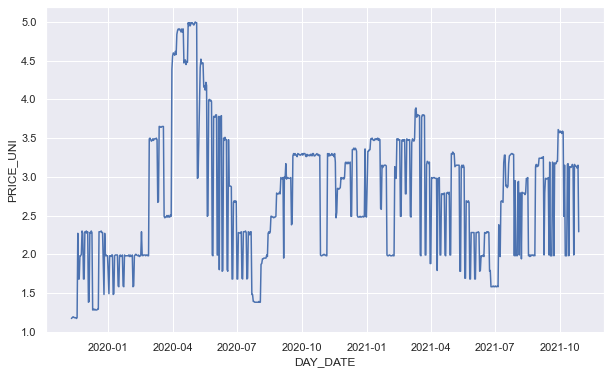

In [211]:
sns.lineplot(data=preço,x='DAY_DATE',y='PRICE_UNI');

## Frozen

In [212]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'CONGELADOS']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
56,425,113,10,R,PERECIVEIS,FLC,CONGELADOS,PIZZAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.30,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
57,426,25,3,R,PERECIVEIS,FLC,CONGELADOS,PIZZAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
117,2977,42,53,R,PERECIVEIS,FLC,CONGELADOS,HAMBURGUER,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.79,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
118,2978,12,1,R,PERECIVEIS,FLC,CONGELADOS,PIZZAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
119,2980,62,5,R,PERECIVEIS,FLC,CONGELADOS,PIZZAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.40,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681356,3099,168,28,R,PERECIVEIS,FLC,CONGELADOS,GELO,2021-10-27,2021,10,27,43,2,4.75,18.0,12.0,13.0,11.0,13.0,18.0,20.0,55.0,54.0,65.0,25.0,25.0,6.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681357,7340,106,59,R,PERECIVEIS,FLC,CONGELADOS,EMPANADOS,2021-10-27,2021,10,27,43,2,104.50,118.0,71.0,47.0,62.0,49.0,60.0,89.0,38.0,54.0,75.0,41.0,84.0,1.80,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681371,5667,7,1,R,PERECIVEIS,FLC,CONGELADOS,LANCHES,2021-10-27,2021,10,27,43,2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681546,11568,55,12,R,PERECIVEIS,FLC,CONGELADOS,EMPANADOS,2021-10-27,2021,10,27,43,2,38.50,36.0,38.0,22.0,24.0,14.0,16.0,13.0,16.0,13.0,12.0,11.0,10.0,4.58,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [213]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,425,113,10,R,PERECIVEIS,FLC,CONGELADOS,PIZZAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.30,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+425,27169,27169+2019-11-10,0
1,426,25,3,R,PERECIVEIS,FLC,CONGELADOS,PIZZAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.33,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+426,27171,27171+2019-11-10,0
2,2977,42,53,R,PERECIVEIS,FLC,CONGELADOS,HAMBURGUER,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.79,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+2977,27165,27165+2019-11-10,0
3,2978,12,1,R,PERECIVEIS,FLC,CONGELADOS,PIZZAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.00,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+2978,0,0+2019-11-10,0
4,2980,62,5,R,PERECIVEIS,FLC,CONGELADOS,PIZZAS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.40,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+2980,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61995,3099,168,28,R,PERECIVEIS,FLC,CONGELADOS,GELO,2021-10-27,2021,10,27,43,2,4.75,18.0,12.0,13.0,11.0,13.0,18.0,20.0,55.0,54.0,65.0,25.0,25.0,6.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+3099,0,0+2021-10-27,0
61996,7340,106,59,R,PERECIVEIS,FLC,CONGELADOS,EMPANADOS,2021-10-27,2021,10,27,43,2,104.50,118.0,71.0,47.0,62.0,49.0,60.0,89.0,38.0,54.0,75.0,41.0,84.0,1.80,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+7340,0,0+2021-10-27,0
61997,5667,7,1,R,PERECIVEIS,FLC,CONGELADOS,LANCHES,2021-10-27,2021,10,27,43,2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+5667,0,0+2021-10-27,0
61998,11568,55,12,R,PERECIVEIS,FLC,CONGELADOS,EMPANADOS,2021-10-27,2021,10,27,43,2,38.50,36.0,38.0,22.0,24.0,14.0,16.0,13.0,16.0,13.0,12.0,11.0,10.0,4.58,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+11568,0,0+2021-10-27,0


In [214]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [215]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.5003008791192777
579.134086007865
24.06520488190086


In [216]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.7270805950738249
316.30419890904477
17.78494303924094


In [217]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.7232028025595396
320.79842699479894
17.910846629760385


## Chocolates

In [218]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'CHOCOLATES']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
108,2097,7,1,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,SNACK,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
144,12218,18,4,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,CANDY BAR,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.50,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
225,11042,32,4,P,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,TABLETE,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.00,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
229,13626,41,5,P,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,BOMBOM,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.20,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
260,10004,1,1,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,CANDY BAR,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681311,7152,17,8,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,SNACK,2021-10-27,2021,10,27,43,2,12.00,8.0,9.0,10.0,7.0,10.0,9.0,10.0,10.0,9.0,10.0,12.0,7.0,2.12,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681492,1983,10,4,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,CONFEITOS,2021-10-27,2021,10,27,43,2,6.50,8.0,11.0,9.0,7.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,4.0,2.50,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681508,23312,19,4,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,TABLETE,2021-10-27,2021,10,27,43,2,7.25,8.0,5.0,12.0,9.0,10.0,11.0,9.0,12.0,7.0,10.0,13.0,13.0,4.75,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681523,23315,15,3,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,SNACK,2021-10-27,2021,10,27,43,2,6.25,7.0,4.0,3.0,3.0,3.0,13.0,6.0,6.0,5.0,5.0,5.0,6.0,5.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [219]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,2097,7,1,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,SNACK,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+2097,0,0+2019-11-10,0
1,12218,18,4,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,CANDY BAR,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.50,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+12218,13626,13626+2019-11-10,1
2,11042,32,4,P,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,TABLETE,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.00,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+11042,0,0+2019-11-10,0
3,13626,41,5,P,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,BOMBOM,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.20,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+13626,0,0+2019-11-10,0
4,10004,1,1,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,CANDY BAR,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+10004,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68712,7152,17,8,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,SNACK,2021-10-27,2021,10,27,43,2,12.00,8.0,9.0,10.0,7.0,10.0,9.0,10.0,10.0,9.0,10.0,12.0,7.0,2.12,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+7152,0,0+2021-10-27,0
68713,1983,10,4,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,CONFEITOS,2021-10-27,2021,10,27,43,2,6.50,8.0,11.0,9.0,7.0,4.0,4.0,4.0,4.0,4.0,3.0,2.0,4.0,2.50,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+1983,26905,26905+2021-10-27,0
68714,23312,19,4,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,TABLETE,2021-10-27,2021,10,27,43,2,7.25,8.0,5.0,12.0,9.0,10.0,11.0,9.0,12.0,7.0,10.0,13.0,13.0,4.75,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+23312,0,0+2021-10-27,0
68715,23315,15,3,R,NAO PERECIVEIS,MERCEARIA,CHOCOLATES,SNACK,2021-10-27,2021,10,27,43,2,6.25,7.0,4.0,3.0,3.0,3.0,13.0,6.0,6.0,5.0,5.0,5.0,6.0,5.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+23315,0,0+2021-10-27,0


In [220]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [221]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.3003923470947861
124.33763534944767
11.150678694565979


In [222]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.5927795182974569
72.37318166903643
8.507242894677242


In [223]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.5916877842780098
72.56720988734551
8.518638969186657


## COFFEE

In [224]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'CAFE']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
175,2113,7,2,R,NAO PERECIVEIS,MERCEARIA,CAFE,SOLUVEL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
188,9882,17,2,P,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.5,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
192,3107,6,1,R,NAO PERECIVEIS,MERCEARIA,CAFE,DIVERSOS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
196,3127,14,4,R,NAO PERECIVEIS,MERCEARIA,CAFE,SOLUVEL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
213,4240,69,6,R,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.5,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681410,1571,576,48,R,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2021-10-27,2021,10,27,43,2,57.75,73.0,71.0,76.0,75.0,48.0,75.0,84.0,67.0,65.0,73.0,46.0,75.0,12.0,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681460,4822,13,2,R,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2021-10-27,2021,10,27,43,2,3.50,5.0,4.0,4.0,5.0,4.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,6.5,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681495,9254,19,2,R,NAO PERECIVEIS,MERCEARIA,CAFE,SOLUVEL,2021-10-27,2021,10,27,43,2,1.25,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,9.5,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681509,22752,54,6,R,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2021-10-27,2021,10,27,43,2,5.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [225]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,2113,7,2,R,NAO PERECIVEIS,MERCEARIA,CAFE,SOLUVEL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+2113,0,0+2019-11-10,0
1,9882,17,2,P,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.5,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+9882,0,0+2019-11-10,0
2,3107,6,1,R,NAO PERECIVEIS,MERCEARIA,CAFE,DIVERSOS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+3107,0,0+2019-11-10,0
3,3127,14,4,R,NAO PERECIVEIS,MERCEARIA,CAFE,SOLUVEL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+3127,0,0+2019-11-10,0
4,4240,69,6,R,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.5,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+4240,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40810,1571,576,48,R,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2021-10-27,2021,10,27,43,2,57.75,73.0,71.0,76.0,75.0,48.0,75.0,84.0,67.0,65.0,73.0,46.0,75.0,12.0,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+1571,0,0+2021-10-27,0
40811,4822,13,2,R,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2021-10-27,2021,10,27,43,2,3.50,5.0,4.0,4.0,5.0,4.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,6.5,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+4822,0,0+2021-10-27,0
40812,9254,19,2,R,NAO PERECIVEIS,MERCEARIA,CAFE,SOLUVEL,2021-10-27,2021,10,27,43,2,1.25,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,2.0,9.5,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+9254,0,0+2021-10-27,0
40813,22752,54,6,R,NAO PERECIVEIS,MERCEARIA,CAFE,TRADICIONAL,2021-10-27,2021,10,27,43,2,5.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+22752,0,0+2021-10-27,0


In [226]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [227]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.4611707270056884
148.847822022808
12.200320570493547


In [228]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.6507690437022953
96.47261170312208
9.822047225661363


In [229]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.6424915651225227
98.75920732847261
9.937766717350161


## MILK

In [230]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'LEITE']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
330,9740,54,17,R,PERECIVEIS,FLC,LEITE,ZERO LACTOSE,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.18,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
457,8245,12,5,R,PERECIVEIS,FLC,LEITE,SEMI DESNATADO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.40,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
633,17831,187,75,R,PERECIVEIS,FLC,LEITE,INTEGRAL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.49,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
634,17833,45,18,R,PERECIVEIS,FLC,LEITE,DESNATADO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
635,17834,80,32,R,PERECIVEIS,FLC,LEITE,SEMI DESNATADO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681081,17505,45,13,R,PERECIVEIS,FLC,LEITE,DESNATADO,2021-10-27,2021,10,27,43,2,12.00,6.0,0.0,0.0,2.0,16.0,18.0,14.0,0.0,7.0,3.0,5.0,11.0,3.46,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681082,17506,583,167,R,PERECIVEIS,FLC,LEITE,INTEGRAL,2021-10-27,2021,10,27,43,2,171.75,176.0,0.0,0.0,0.0,0.0,0.0,326.0,0.0,2.0,120.0,13.0,137.0,3.49,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681119,26851,98,14,R,PERECIVEIS,FLC,LEITE,ESPECIAL,2021-10-27,2021,10,27,43,2,3.50,6.0,6.0,7.0,7.0,7.0,7.0,5.0,8.0,7.0,6.0,6.0,7.0,7.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681120,26853,4,1,R,PERECIVEIS,FLC,LEITE,ESPECIAL,2021-10-27,2021,10,27,43,2,2.00,3.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,4.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [231]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,9740,54,17,R,PERECIVEIS,FLC,LEITE,ZERO LACTOSE,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.18,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+9740,0,0+2019-11-10,0
1,8245,12,5,R,PERECIVEIS,FLC,LEITE,SEMI DESNATADO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.40,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+8245,0,0+2019-11-10,0
2,17831,187,75,R,PERECIVEIS,FLC,LEITE,INTEGRAL,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.49,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+17831,0,0+2019-11-10,0
3,17833,45,18,R,PERECIVEIS,FLC,LEITE,DESNATADO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+17833,0,0+2019-11-10,0
4,17834,80,32,R,PERECIVEIS,FLC,LEITE,SEMI DESNATADO,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,0,1.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+17834,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15741,17505,45,13,R,PERECIVEIS,FLC,LEITE,DESNATADO,2021-10-27,2021,10,27,43,2,12.00,6.0,0.0,0.0,2.0,16.0,18.0,14.0,0.0,7.0,3.0,5.0,11.0,3.46,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+17505,0,0+2021-10-27,0
15742,17506,583,167,R,PERECIVEIS,FLC,LEITE,INTEGRAL,2021-10-27,2021,10,27,43,2,171.75,176.0,0.0,0.0,0.0,0.0,0.0,326.0,0.0,2.0,120.0,13.0,137.0,3.49,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+17506,0,0+2021-10-27,0
15743,26851,98,14,R,PERECIVEIS,FLC,LEITE,ESPECIAL,2021-10-27,2021,10,27,43,2,3.50,6.0,6.0,7.0,7.0,7.0,7.0,5.0,8.0,7.0,6.0,6.0,7.0,7.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+26851,0,0+2021-10-27,0
15744,26853,4,1,R,PERECIVEIS,FLC,LEITE,ESPECIAL,2021-10-27,2021,10,27,43,2,2.00,3.0,2.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,4.00,0,1.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+26853,0,0+2021-10-27,0


In [232]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [233]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.4792904115469975
4492.111111111111
67.02321322580045


In [234]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.5733408359953056
3680.7472222222223
60.66916203659172


In [235]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.5730658564085369
3683.1194444444445
60.68870936545318


## TOILET PAPER

In [236]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'PAPEL HIGIENICO']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
432,14192,38,2,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
448,11616,153,9,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
591,19435,935,78,P,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.99,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
1383,7520,28,5,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
1651,25264,180,15,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2679857,7519,48,8,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2021-10-27,2021,10,27,43,2,11.25,11.0,11.0,11.0,9.0,9.0,9.0,10.0,13.0,15.0,13.0,9.0,7.0,6.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2680591,28043,18,1,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2021-10-27,2021,10,27,43,2,2.00,16.0,4.0,15.0,4.0,24.0,10.0,13.0,53.0,33.0,50.0,52.0,38.0,18.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2680839,16895,47,2,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2021-10-27,2021,10,27,43,2,2.25,3.0,2.0,3.0,3.0,3.0,4.0,3.0,6.0,4.0,7.0,5.0,6.0,23.50,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681244,11616,184,9,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2021-10-27,2021,10,27,43,2,39.25,52.0,76.0,60.0,78.0,59.0,72.0,86.0,57.0,79.0,57.0,59.0,46.0,20.44,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [237]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,14192,38,2,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+14192,11616,11616+2019-11-10,0
1,11616,153,9,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+11616,19435,19435+2019-11-10,1
2,19435,935,78,P,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.99,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+19435,11616,11616+2019-11-10,0
3,7520,28,5,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.60,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+7520,0,0+2019-11-10,0
4,25264,180,15,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+25264,11616,11616+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9185,7519,48,8,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2021-10-27,2021,10,27,43,2,11.25,11.0,11.0,11.0,9.0,9.0,9.0,10.0,13.0,15.0,13.0,9.0,7.0,6.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+7519,2139,2139+2021-10-27,0
9186,28043,18,1,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2021-10-27,2021,10,27,43,2,2.00,16.0,4.0,15.0,4.0,24.0,10.0,13.0,53.0,33.0,50.0,52.0,38.0,18.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+28043,0,0+2021-10-27,0
9187,16895,47,2,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2021-10-27,2021,10,27,43,2,2.25,3.0,2.0,3.0,3.0,3.0,4.0,3.0,6.0,4.0,7.0,5.0,6.0,23.50,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+16895,11616,11616+2021-10-27,0
9188,11616,184,9,R,NAO PERECIVEIS,HIGIENE,PAPEL HIGIENICO,FOLHA DUPLA,2021-10-27,2021,10,27,43,2,39.25,52.0,76.0,60.0,78.0,59.0,72.0,86.0,57.0,79.0,57.0,59.0,46.0,20.44,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+11616,19435,19435+2021-10-27,1


In [238]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [239]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.14869616831095045
1182.6290849673203
34.389374594012615


In [240]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.7713166822946109
317.6862745098039
17.823755903563196


In [241]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.7972244565274101
281.69526143790847
16.783779712505417


## Premium beer

In [242]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'CERVEJA PREMIUM']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
55,423,330,92,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,LAGER,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.59,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
189,9883,5,2,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,LAGER,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
308,13855,153,23,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,PILSEN,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.65,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
444,2283,8,2,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,ESCURA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
569,22676,5,2,P,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,PILSEN,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681399,23709,80,19,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,LAGER,2021-10-27,2021,10,27,43,2,6.50,20.0,20.0,19.0,16.0,17.0,16.0,21.0,24.0,21.0,20.0,26.0,20.0,4.21,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681400,23710,58,15,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,PILSEN,2021-10-27,2021,10,27,43,2,17.50,29.0,48.0,24.0,32.0,33.0,42.0,30.0,50.0,55.0,48.0,9.0,63.0,3.87,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681415,7220,59,18,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,LAGER,2021-10-27,2021,10,27,43,2,27.25,28.0,36.0,47.0,35.0,34.0,51.0,48.0,81.0,59.0,65.0,49.0,66.0,3.28,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2681483,22908,18,5,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,PILSEN,2021-10-27,2021,10,27,43,2,6.25,14.0,8.0,9.0,5.0,7.0,14.0,11.0,14.0,15.0,0.0,7.0,6.0,3.60,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [243]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,423,330,92,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,LAGER,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.59,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+423,0,0+2019-11-10,0
1,9883,5,2,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,LAGER,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+9883,0,0+2019-11-10,0
2,13855,153,23,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,PILSEN,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.65,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+13855,0,0+2019-11-10,0
3,2283,8,2,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,ESCURA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+2283,0,0+2019-11-10,0
4,22676,5,2,P,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,PILSEN,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.50,1,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+22676,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23794,23709,80,19,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,LAGER,2021-10-27,2021,10,27,43,2,6.50,20.0,20.0,19.0,16.0,17.0,16.0,21.0,24.0,21.0,20.0,26.0,20.0,4.21,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+23709,0,0+2021-10-27,0
23795,23710,58,15,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,PILSEN,2021-10-27,2021,10,27,43,2,17.50,29.0,48.0,24.0,32.0,33.0,42.0,30.0,50.0,55.0,48.0,9.0,63.0,3.87,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+23710,0,0+2021-10-27,0
23796,7220,59,18,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,LAGER,2021-10-27,2021,10,27,43,2,27.25,28.0,36.0,47.0,35.0,34.0,51.0,48.0,81.0,59.0,65.0,49.0,66.0,3.28,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+7220,0,0+2021-10-27,0
23797,22908,18,5,R,NAO PERECIVEIS,BEBIDAS,CERVEJA PREMIUM,PILSEN,2021-10-27,2021,10,27,43,2,6.25,14.0,8.0,9.0,5.0,7.0,14.0,11.0,14.0,15.0,0.0,7.0,6.0,3.60,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+22908,0,0+2021-10-27,0


In [244]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [245]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.3443883348011133
422.551917989418
20.556067668438388


In [246]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.5332719458843469
300.81349206349205
17.3439756706325


In [247]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.537168272910878
298.30224867724866
17.271428680837282


## OIL

In [248]:
canibalismo_L4 = canibalismo_total.loc[canibalismo_total['MERCH_L4_DESC'] == 'OLEO']
canibalismo_L4

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos
126,3014,192,55,R,NAO PERECIVEIS,MERCEARIA,OLEO,SOJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.49,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
178,2130,195,55,R,NAO PERECIVEIS,MERCEARIA,OLEO,SOJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.55,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
349,3250,14,2,R,NAO PERECIVEIS,MERCEARIA,OLEO,ESPECIAIS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
350,3251,32,5,R,NAO PERECIVEIS,MERCEARIA,OLEO,ESPECIAIS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.40,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
887,24648,7,2,R,NAO PERECIVEIS,MERCEARIA,OLEO,N.T.,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.50,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2678650,26424,71,2,R,NAO PERECIVEIS,MERCEARIA,OLEO,DIVERSOS,2021-10-27,2021,10,27,43,2,0.25,1.0,1.0,2.0,2.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,35.50,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2678815,19296,15,1,R,NAO PERECIVEIS,MERCEARIA,OLEO,ESPECIAIS,2021-10-27,2021,10,27,43,2,8.50,2.0,2.0,4.0,6.0,3.0,3.0,7.0,5.0,8.0,3.0,4.0,5.0,15.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2679278,13265,37,1,R,NAO PERECIVEIS,MERCEARIA,OLEO,DIVERSOS,2021-10-27,2021,10,27,43,2,0.00,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,37.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490
2679454,2130,1262,160,R,NAO PERECIVEIS,MERCEARIA,OLEO,SOJA,2021-10-27,2021,10,27,43,2,229.50,136.0,119.0,149.0,196.0,144.0,114.0,73.0,22.0,58.0,106.0,121.0,132.0,7.89,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490


In [249]:
SKUs_total = canibalismo_L4['SKU_KEY'].unique()
SKUs_total = np.sort(SKUs_total)

ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df1 = pd.DataFrame(calendar_df2, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df2 = pd.DataFrame(calendar_df2, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df1.iloc[:, i] = SKUs_total[i]
for i in range(len(SKUs_total)):
    canibal_df2.iloc[:, i] = SKUs_total[i]
    
join_skus_L4 = pd.concat([calendar_df2, canibal_df1, canibal_df2], axis =1)
col_L4 = join_skus_L4.columns.values

for i in range(len(col_L4)-1):
    join_skus_L4.iloc[:, i+1] = join_skus_L4.iloc[:, 0].astype(str) + space + join_skus_L4.iloc[:, i+1].astype(str)

canibalismo_L4["CONCAT_SKU_KEY"] = canibalismo_L4["DAY_DATE"].astype(str) + space + canibalismo_L4["SKU_KEY"].astype(str)
canibalismo_L4_v1 = canibalismo_L4[['CONCAT_SKU_KEY', 'SLS_QTY', 'PROMOCIONAL']]
    
ohe = ohc.fit_transform(canibalismo_L4.SKU_KEY.values.reshape(-1,1)).toarray()
canibal_df3 = pd.DataFrame(canibalismo_L4_v1, columns = ['SLS_QTY_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df4 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df5 = pd.DataFrame(canibalismo_L4_v1, columns = ['SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])
canibal_df6 = pd.DataFrame(canibalismo_L4_v1, columns = ['PROMO_SKU_'+str(ohc.categories_[0][i])for i in range(len(ohc.categories_[0]))])

for i in range(len(SKUs_total)):
    canibal_df3.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df4.iloc[:, i] = canibalismo_L4_v1['CONCAT_SKU_KEY']
for i in range(len(SKUs_total)):
    canibal_df5.iloc[:, i] = canibalismo_L4_v1['SLS_QTY']
for i in range(len(SKUs_total)):
    canibal_df6.iloc[:, i] = canibalismo_L4_v1['PROMOCIONAL']
    
join_canibalismo_L4 = pd.concat([canibal_df3, canibal_df4, canibal_df5, canibal_df6], axis =1)

col_L4_v2 = join_canibalismo_L4.columns.values
x1 = int(len(col_L4_v2)/2)
x2 = int(x1/2)

for i in range(len(col_L4_v2)-x1):
    join_skus_L4 = join_skus_L4.merge(join_canibalismo_L4[[col_L4_v2[i], col_L4_v2[i+x1]]], on =col_L4_v2[i], how = 'left')
    
join_skus_L4.drop(join_skus_L4.iloc[:, 1:(x1+1)], inplace = True, axis = 1)
join_skus_L4 = join_skus_L4.fillna(0)

df_corrM_L4 = join_skus_L4.corr().reset_index()

df_corrM_L4 = df_corrM_L4.fillna(0)
df_corrM_L4.drop(df_corrM_L4.iloc[:, (x2+1):(x1+1)], inplace = True, axis = 1)
df_corrM_L4 = df_corrM_L4.drop(df_corrM_L4.index[0:x2])
df_corrM_L4['A'], df_corrM_L4['SKU_KEY'] = df_corrM_L4['index'].str.split('_SKU_', 1).str

col_L4_v3 = df_corrM_L4.columns.values

for i in range(len(col_L4_v3)-2):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] > df_corrM_L4[col_L4_v3[i+1]].min(), col_L4_v3[i+1]] = 0

for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]].astype(float) > limite_cabibalismo, col_L4_v3[i+1]] = 0
    
for i in range(len(col_L4_v3)-3):
    df_corrM_L4.loc[df_corrM_L4[col_L4_v3[i+1]] != 0, col_L4_v3[i+1]] = df_corrM_L4['SKU_KEY']     

    df_corrM_L4['SKUs_Canibal'] = 0

for i in range(len(col_L4_v3)-4):
    df_corrM_L4[col_L4_v3[i+1]] = pd.to_numeric(df_corrM_L4[col_L4_v3[i+1]], downcast='integer') 
    
for i in range(len(col_L4_v3)-4):
    df_corrM_L4.at[i+x2, 'SKUs_Canibal'] = df_corrM_L4[col_L4_v3[i+1]].max()
    
df_corrM_L4['SKU_KEY'] = pd.to_numeric(df_corrM_L4['SKU_KEY'], downcast='integer')
df_corrM_L4 = df_corrM_L4[['SKU_KEY', 'SKUs_Canibal']]

canibalismo_L4_df = pd.merge(canibalismo_L4,df_corrM_L4,how='left',on='SKU_KEY')
canibalismo_L4_df["CONCAT_PROMO"] = canibalismo_L4_df["SKUs_Canibal"].astype(str) + space + canibalismo_L4_df["DAY_DATE"].astype(str)

canibalismo_L4_v2 = canibalismo_L4
canibalismo_L4_v2["CONCAT_PROMO"] = canibalismo_L4["SKU_KEY"].astype(str) + space + canibalismo_L4["DAY_DATE"].astype(str)
canibalismo_L4_v2["PROMO_CANIBAL"] = canibalismo_L4_v2["PROMOCIONAL"]
canibalismo_L4_v2 = canibalismo_L4_v2[['CONCAT_PROMO', 'PROMO_CANIBAL']]

canibalismo_L4_df_v2 = pd.merge(canibalismo_L4_df,canibalismo_L4_v2,how='left',on='CONCAT_PROMO')
canibalismo_L4_df_v2 = canibalismo_L4_df_v2.fillna(0)
canibalismo_L4_df_v2['PROMO_CANIBAL'] = pd.to_numeric(canibalismo_L4_df_v2['PROMO_CANIBAL'], downcast='integer')
canibalismo_L4_df_v2

,SKU_KEY,SLS_VAL,SLS_QTY,TRAN_TYPE,MERCH_L2_DESC,MERCH_L3_DESC,MERCH_L4_DESC,MERCH_L5_DESC,DAY_DATE,YEAR,MONTH,DAY,WEEK_NUMBER,DAY_OF_WEEK,MEAN_QTY,QTY_M-1,QTY_M-2,QTY_M-3,QTY_M-4,QTY_M-5,QTY_M-6,QTY_M-7,QTY_M-8,QTY_M-9,QTY_M-10,QTY_M-11,QTY_M-12,PRICE_UNI,PROMOCIONAL,PERECIVEIS,YEAR_B,week_sin,week_cos,day_sin,day_cos,CONCAT_SKU_KEY,SKUs_Canibal,CONCAT_PROMO,PROMO_CANIBAL
0,3014,192,55,R,NAO PERECIVEIS,MERCEARIA,OLEO,SOJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.49,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+3014,0,0+2019-11-10,0
1,2130,195,55,R,NAO PERECIVEIS,MERCEARIA,OLEO,SOJA,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.55,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+2130,0,0+2019-11-10,0
2,3250,14,2,R,NAO PERECIVEIS,MERCEARIA,OLEO,ESPECIAIS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.00,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+3250,0,0+2019-11-10,0
3,3251,32,5,R,NAO PERECIVEIS,MERCEARIA,OLEO,ESPECIAIS,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.40,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+3251,0,0+2019-11-10,0
4,24648,7,2,R,NAO PERECIVEIS,MERCEARIA,OLEO,N.T.,2019-11-10,2019,11,10,45,6,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.50,0,0.0,0.0,-0.875735,-0.875735,-0.974928,-0.222521,2019-11-10+24648,0,0+2019-11-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083,26424,71,2,R,NAO PERECIVEIS,MERCEARIA,OLEO,DIVERSOS,2021-10-27,2021,10,27,43,2,0.25,1.0,1.0,2.0,2.0,1.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,35.50,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+26424,0,0+2021-10-27,0
7084,19296,15,1,R,NAO PERECIVEIS,MERCEARIA,OLEO,ESPECIAIS,2021-10-27,2021,10,27,43,2,8.50,2.0,2.0,4.0,6.0,3.0,3.0,7.0,5.0,8.0,3.0,4.0,5.0,15.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+19296,0,0+2021-10-27,0
7085,13265,37,1,R,NAO PERECIVEIS,MERCEARIA,OLEO,DIVERSOS,2021-10-27,2021,10,27,43,2,0.00,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,37.00,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+13265,0,0+2021-10-27,0
7086,2130,1262,160,R,NAO PERECIVEIS,MERCEARIA,OLEO,SOJA,2021-10-27,2021,10,27,43,2,229.50,136.0,119.0,149.0,196.0,144.0,114.0,73.0,22.0,58.0,106.0,121.0,132.0,7.89,0,0.0,0.0,-0.964636,-0.964636,0.781831,0.623490,2021-10-27+2130,0,0+2021-10-27,0


In [250]:
df_training_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_1) & (canibalismo_L4_df_v2['DAY_DATE'] < split_date_2)]
df_test_v3 = canibalismo_L4_df_v2.loc[(canibalismo_L4_df_v2['DAY_DATE'] >= split_date_2)]

In [251]:
y_test = df_test_v3['SLS_QTY']
y_base_line =df_test_v3['MEAN_QTY'].round(0).astype(int)

print(r2_score(y_test,y_base_line))
print(mean_squared_error(y_test,y_base_line))
print(np.sqrt(mean_squared_error(y_test,y_base_line)))

0.6578504385303061
2210.159183673469
47.012330123845906


In [252]:
x_training_v1 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]
y_training_v1 = df_training_v3['SLS_QTY']

x_test_v1 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12']]

boosting_regr_v1 = GradientBoostingRegressor(random_state=0)
boosting_regr_v1.fit(x_training_v1, y_training_v1)
y_prediction_boosting_regr_v1 = boosting_regr_v1.predict(x_test_v1).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v1))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v1))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v1)))

0.709967330895115
1873.5034013605443
43.28398550688862


In [253]:
x_training_v2 = df_training_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]
y_training_v2 = df_training_v3['SLS_QTY']

x_test_v2 = df_test_v3[['SKU_KEY', 'MEAN_QTY','PRICE_UNI', 'PROMOCIONAL', 'PERECIVEIS', 'YEAR_B', 'week_sin', 'week_cos', 'day_sin', 'day_cos', 'QTY_M-1', 'QTY_M-2', 'QTY_M-3', 'QTY_M-4', 'QTY_M-5', 'QTY_M-6', 'QTY_M-7', 'QTY_M-8', 'QTY_M-9', 'QTY_M-10', 'QTY_M-11', 'QTY_M-12', 'PROMO_CANIBAL']]

boosting_regr_v2 = GradientBoostingRegressor(random_state=0)
boosting_regr_v2.fit(x_training_v2, y_training_v2)
y_prediction_boosting_regr_v2 = boosting_regr_v2.predict(x_test_v2).round(0).astype(int)

print(r2_score(y_test,y_prediction_boosting_regr_v2))
print(mean_squared_error(y_test,y_prediction_boosting_regr_v2))
print(np.sqrt(mean_squared_error(y_test,y_prediction_boosting_regr_v2)))

0.7101234022865616
1872.4952380952382
43.27233802436885
